In [1]:
import glob, json, argparse, os, sys
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from Bio.PDB import *

sys.path.insert(0,'/data1/groups/keatinglab/swans/savinovCollaboration/inhibitory_fragments_structure_prediction')
from src.colabfold_process_output_utils import *
from src.colabfold_process_output import *
from src.analyze_predictions import *
from src.peak_prediction import *

# Import data

In [2]:
df = pd.read_csv('/data1/groups/keatinglab/swans/savinovCollaboration/analysis/process_colabfold_output/colabfold_predictions.csv',index_col=0)
print(len(df))
df.head(3)

4621


,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,gene,condition
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA,30aa_monomer_folA
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA,30aa_monomer_folA
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,folA,30aa_monomer_folA


In [3]:
df.gene.unique()

array(['folA', 'fstZ', 'groL', 'gyrA', 'lptG', 'rplL', 'ssb'],
      dtype=object)

In [4]:
path_to_experimental_df = '/home/gridsan/sswanson/keatinglab_shared/swans/savinovCollaboration/inhibitory_fragments_structure_prediction/data/Savinov_2022_inhib_peptide_mapping.csv'
exp_df = pd.read_csv(path_to_experimental_df)
print(len(exp_df))
exp_df.head(3)

12080


,gene,fragment ID,fragment start (aa),fragment end (aa),fragment center (aa),fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_45_+,6,15,10.5,10,0.277702,0.038327,hydrophobic,unstable,negative,1.0,1.0,0.0,N-terminal
1,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_90_+,6,30,18.0,25,-0.417512,0.105113,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal
2,EGFP-coding-pEGFP,EGFP-coding-pEGFP_16_165_+,6,55,30.5,50,-0.461540,0.310617,hydrophobic,stable,negative,1.0,1.0,0.0,N-terminal


In [5]:
exp_df.gene.unique()

array(['EGFP-coding-pEGFP', 'folA-coding-EcoliBL21DE3',
       'ftsZ-coding-EcoliBL21DE3', 'groL-coding-EcoliBL21DE3',
       'groS-coding-EcoliBL21DE3', 'gyrA-coding-EcoliBL21DE3',
       'ileS-coding-EcoliBL21DE3', 'lptG-coding-EcoliBL21DE3',
       'rpIL-coding-EcoliBL21DE3', 'rpoB-coding-EcoliBL21DE3',
       'ssb-coding-EcoliBL21DE3'], dtype=object)

## merge predicted and experimental dataframes

In [6]:
df['gene'] = df['fragment_name'].apply(lambda x: x.split('_')[-2])
print(df['gene'].unique())
df = df.replace({
    'folA':'folA-coding-EcoliBL21DE3',
    'FtsZ':'ftsZ-coding-EcoliBL21DE3',
    'groEL':'groL-coding-EcoliBL21DE3',
    'gyrA':'gyrA-coding-EcoliBL21DE3',
    'lptG':'lptG-coding-EcoliBL21DE3',
    'rpIL':'rpIL-coding-EcoliBL21DE3',
    'ssb':'ssb-coding-EcoliBL21DE3'
})
df.head()

['folA' 'FtsZ' 'groEL' 'gyrA' 'lptG' 'rpIL' 'rplL' 'ssb']


,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,gene,condition
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA-coding-EcoliBL21DE3,30aa_monomer_folA
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,folA-coding-EcoliBL21DE3,30aa_monomer_folA
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,folA-coding-EcoliBL21DE3,30aa_monomer_folA
3,folA_1-159_folA_10-39,10,24.5,39,0.123641,83.581000,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.247281,folA-coding-EcoliBL21DE3,30aa_monomer_folA
4,folA_1-159_folA_11-40,11,25.5,40,0.143685,83.008667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.143685,folA-coding-EcoliBL21DE3,30aa_monomer_folA


In [7]:
df.groupby(['gene','condition','fragment start (aa)','fragment center (aa)','fragment end (aa)']).ngroups

4621

In [19]:
merge_on_list = ['gene','fragment start (aa)']#,'fragment center (aa)','fragment end (aa)']
exp_30_df = exp_df[(exp_df['fragment length (aa)']==30)|((exp_df['fragment length (aa)']==14)&(exp_df['gene']=='lptG-coding-EcoliBL21DE3'))].copy(deep=True)
exp_30_df = exp_30_df.drop(columns=['fragment center (aa)','fragment end (aa)'])
merge_df = df.merge(exp_30_df,how='left',on=merge_on_list,validate='many_to_one')
merge_df

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,fragment length (aa),E = inhibitory effect (enrichment),sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier
0,folA_1-159_folA_7-36,7,21.5,36,0.103046,84.774000,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-2.770798,0.451855,hydrophobic,stable,neutral,1.0,1.0,1.0,N-terminal
1,folA_1-159_folA_8-37,8,22.5,37,0.105501,86.700667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-1.798765,0.569595,hydrophilic,stable,neutral,1.0,1.0,1.0,N-terminal
2,folA_1-159_folA_9-38,9,23.5,38,0.123415,83.461667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.123415,...,30.0,-0.973027,0.270458,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
3,folA_1-159_folA_10-39,10,24.5,39,0.123641,83.581000,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.247281,...,30.0,-1.108710,0.243684,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
4,folA_1-159_folA_11-40,11,25.5,40,0.143685,83.008667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.143685,...,30.0,-1.242470,0.046579,hydrophilic,unstable,positive,1.0,1.0,1.0,N-terminal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4616,ssb4copies_1-178_ssb_145-174,145,159.5,174,0.689092,35.271667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-0.924184,0.048997,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
4617,ssb4copies_1-178_ssb_146-175,146,160.5,175,0.687369,36.244667,0,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.000000,...,30.0,-0.436107,0.160560,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
4618,ssb4copies_1-178_ssb_147-176,147,161.5,176,0.683096,31.469667,1,/data1/groups/keatinglab/swans/savinovCollabor...,both,0.683096,...,30.0,0.508135,0.121051,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal
4619,ssb4copies_1-178_ssb_148-177,148,162.5,177,0.690097,34.799667,2,/data1/groups/keatinglab/swans/savinovCollabor...,both,1.380195,...,30.0,-0.399455,0.222227,hydrophilic,unstable,negative,0.0,0.0,0.0,C-terminal


# Get predictions

In [21]:
def generatePredictionsFromAlphaFold(pred_df: pd.DataFrame,
                        pred_metric_name: str,
                        pred_metric_cutoff: float,
                        cluster_d_cutoff: float = 0.5,
                        only_output_df: bool = False) -> pd.DataFrame:

    # filter dataframe by selected metric
    filt_pred_df = pred_df[pred_df[pred_metric_name]>=pred_metric_cutoff]
    print(f"Original dataframe had {len(pred_df)} predicted fragments, while new dataframe has {len(filt_pred_df)} passing the cutoff")

    # group by condition and cluster by contacts
    parser = PDBParser(QUIET=True)
    df_list = []
    for (gene,condition),group_df in filt_pred_df.groupby(['gene','condition']):
        print(f"clustering {len(group_df)} predictions from {gene}_{condition} ...")

        # define contacts
        contacts_list = []
        for i,row in group_df.iterrows():
            s_extract = parser.get_structure("s", row['path'])
            fixResidueNumbers(s_extract[0]['B'],row['fragment start (aa)'])
            contacts_residues = getInterfaceContactsFromStructure(s_extract,{'A'},{'B'},4.0)
            # print(f"pred fragment {row['fragment_name']} has {len(contacts_residues)} contacts")
            contacts_list.append(contacts_residues)
        group_df['contact_set'] = contacts_list

        # get similarity matrix
        sim_list = []
        for frag_contacts_a in group_df['contact_set']:
            for frag_contacts_b in group_df['contact_set']:
                sim_list.append(contactOverlap(frag_contacts_a,frag_contacts_b))
        sim_matrix = np.array(sim_list).reshape(len(group_df['contact_set']),len(group_df['contact_set']))
        if not only_output_df:
            plt.figure(figsize = (40,40))
            ax = sns.heatmap(sim_matrix,
                        xticklabels=group_df['fragment start (aa)'],
                        yticklabels=group_df['fragment start (aa)'])
            ax.set_xlabel('fragment start (aa)')
            ax.set_ylabel('fragment start (aa)')
            plt.savefig(f"{gene}-{condition}_contactsim_fragments{pred_metric_cutoff}{pred_metric_name}.png",dpi=300)

        # hierarchically cluster
        dist_matrix = 1 - sim_matrix
        condensed_dist_matrix = scipy.spatial.distance.squareform(dist_matrix,force='tovector')
        linkage_matrix = scipy.cluster.hierarchy.linkage(condensed_dist_matrix, method='single', optimal_ordering=False)
        clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, t=cluster_d_cutoff, criterion='distance')
        print(f"{len(clusters)} fragments in {clusters.max()} clusters")
        print(clusters)
        group_df['cluster'] = clusters
        # Get the cluster representative for each cluster
        pred_clusrep_df = group_df.loc[group_df.groupby('cluster')[pred_metric_name].idxmax()].sort_values(by='fragment start (aa)')
        # get the first and last member for each cluster (to define the range of fragments that fall into it)
        cluster_size = []
        first_fragment_center = []
        last_fragment_center = []
        for i,row in pred_clusrep_df.iterrows():
            cluster_n = row['cluster']
            cluster_n_df = group_df[group_df['cluster']==cluster_n]
            cluster_size.append(len(cluster_n_df))
            first_fragment_center.append(cluster_n_df['fragment center (aa)'].min())
            last_fragment_center.append(cluster_n_df['fragment center (aa)'].max())
        pred_clusrep_df['cluster_size'] = cluster_size
        pred_clusrep_df['cluster first fragment center (aa)'] = first_fragment_center
        pred_clusrep_df['cluster last fragment center (aa)'] = last_fragment_center

        df_list.append(pred_clusrep_df)

        # create directory for storing cluster representatives
        if not only_output_df:
            dir_name = f"{gene}_{condition}"
            try:
                os.mkdir(dir_name)
            except FileExistsError:
                pass
            for i,row in pred_clusrep_df.iterrows():
                file = row['path'].split('/')[-1]
                shutil.copyfile(row['path'],os.path.join(dir_name,file))

        # write out cluster info to file
        if not only_output_df:
            plt.figure(figsize = (10,5))
            exp_df = pred_df[(pred_df['gene']==gene)&(pred_df['condition']==condition)]
            ax = sns.lineplot(data=exp_df,x='fragment center (aa)',y='E = inhibitory effect (enrichment)',zorder=1)
            ax.axhline(-3,c='r',ls='--')
            fcenter = pred_clusrep_df['fragment center (aa)']
            wcontacts = pred_clusrep_df['weighted_contacts']/pred_clusrep_df['weighted_contacts'].max()*exp_df['E = inhibitory effect (enrichment)'].min()
            sns.scatterplot(x=fcenter,y=wcontacts,color='black',ax=ax,zorder=2)
            plt.show()
            plt.savefig(f"{gene}-{condition}_{pred_metric_cutoff}{pred_metric_name}_inhibeffect_vs_clusrepfragments.png",dpi=300)

    return pd.concat(df_list)


Original dataframe had 4621 predicted fragments, while new dataframe has 594 passing the cutoff
clustering 2 predictions from folA-coding-EcoliBL21DE3_30aa_monomer_folA ...
2 fragments in 2 clusters
[1 2]


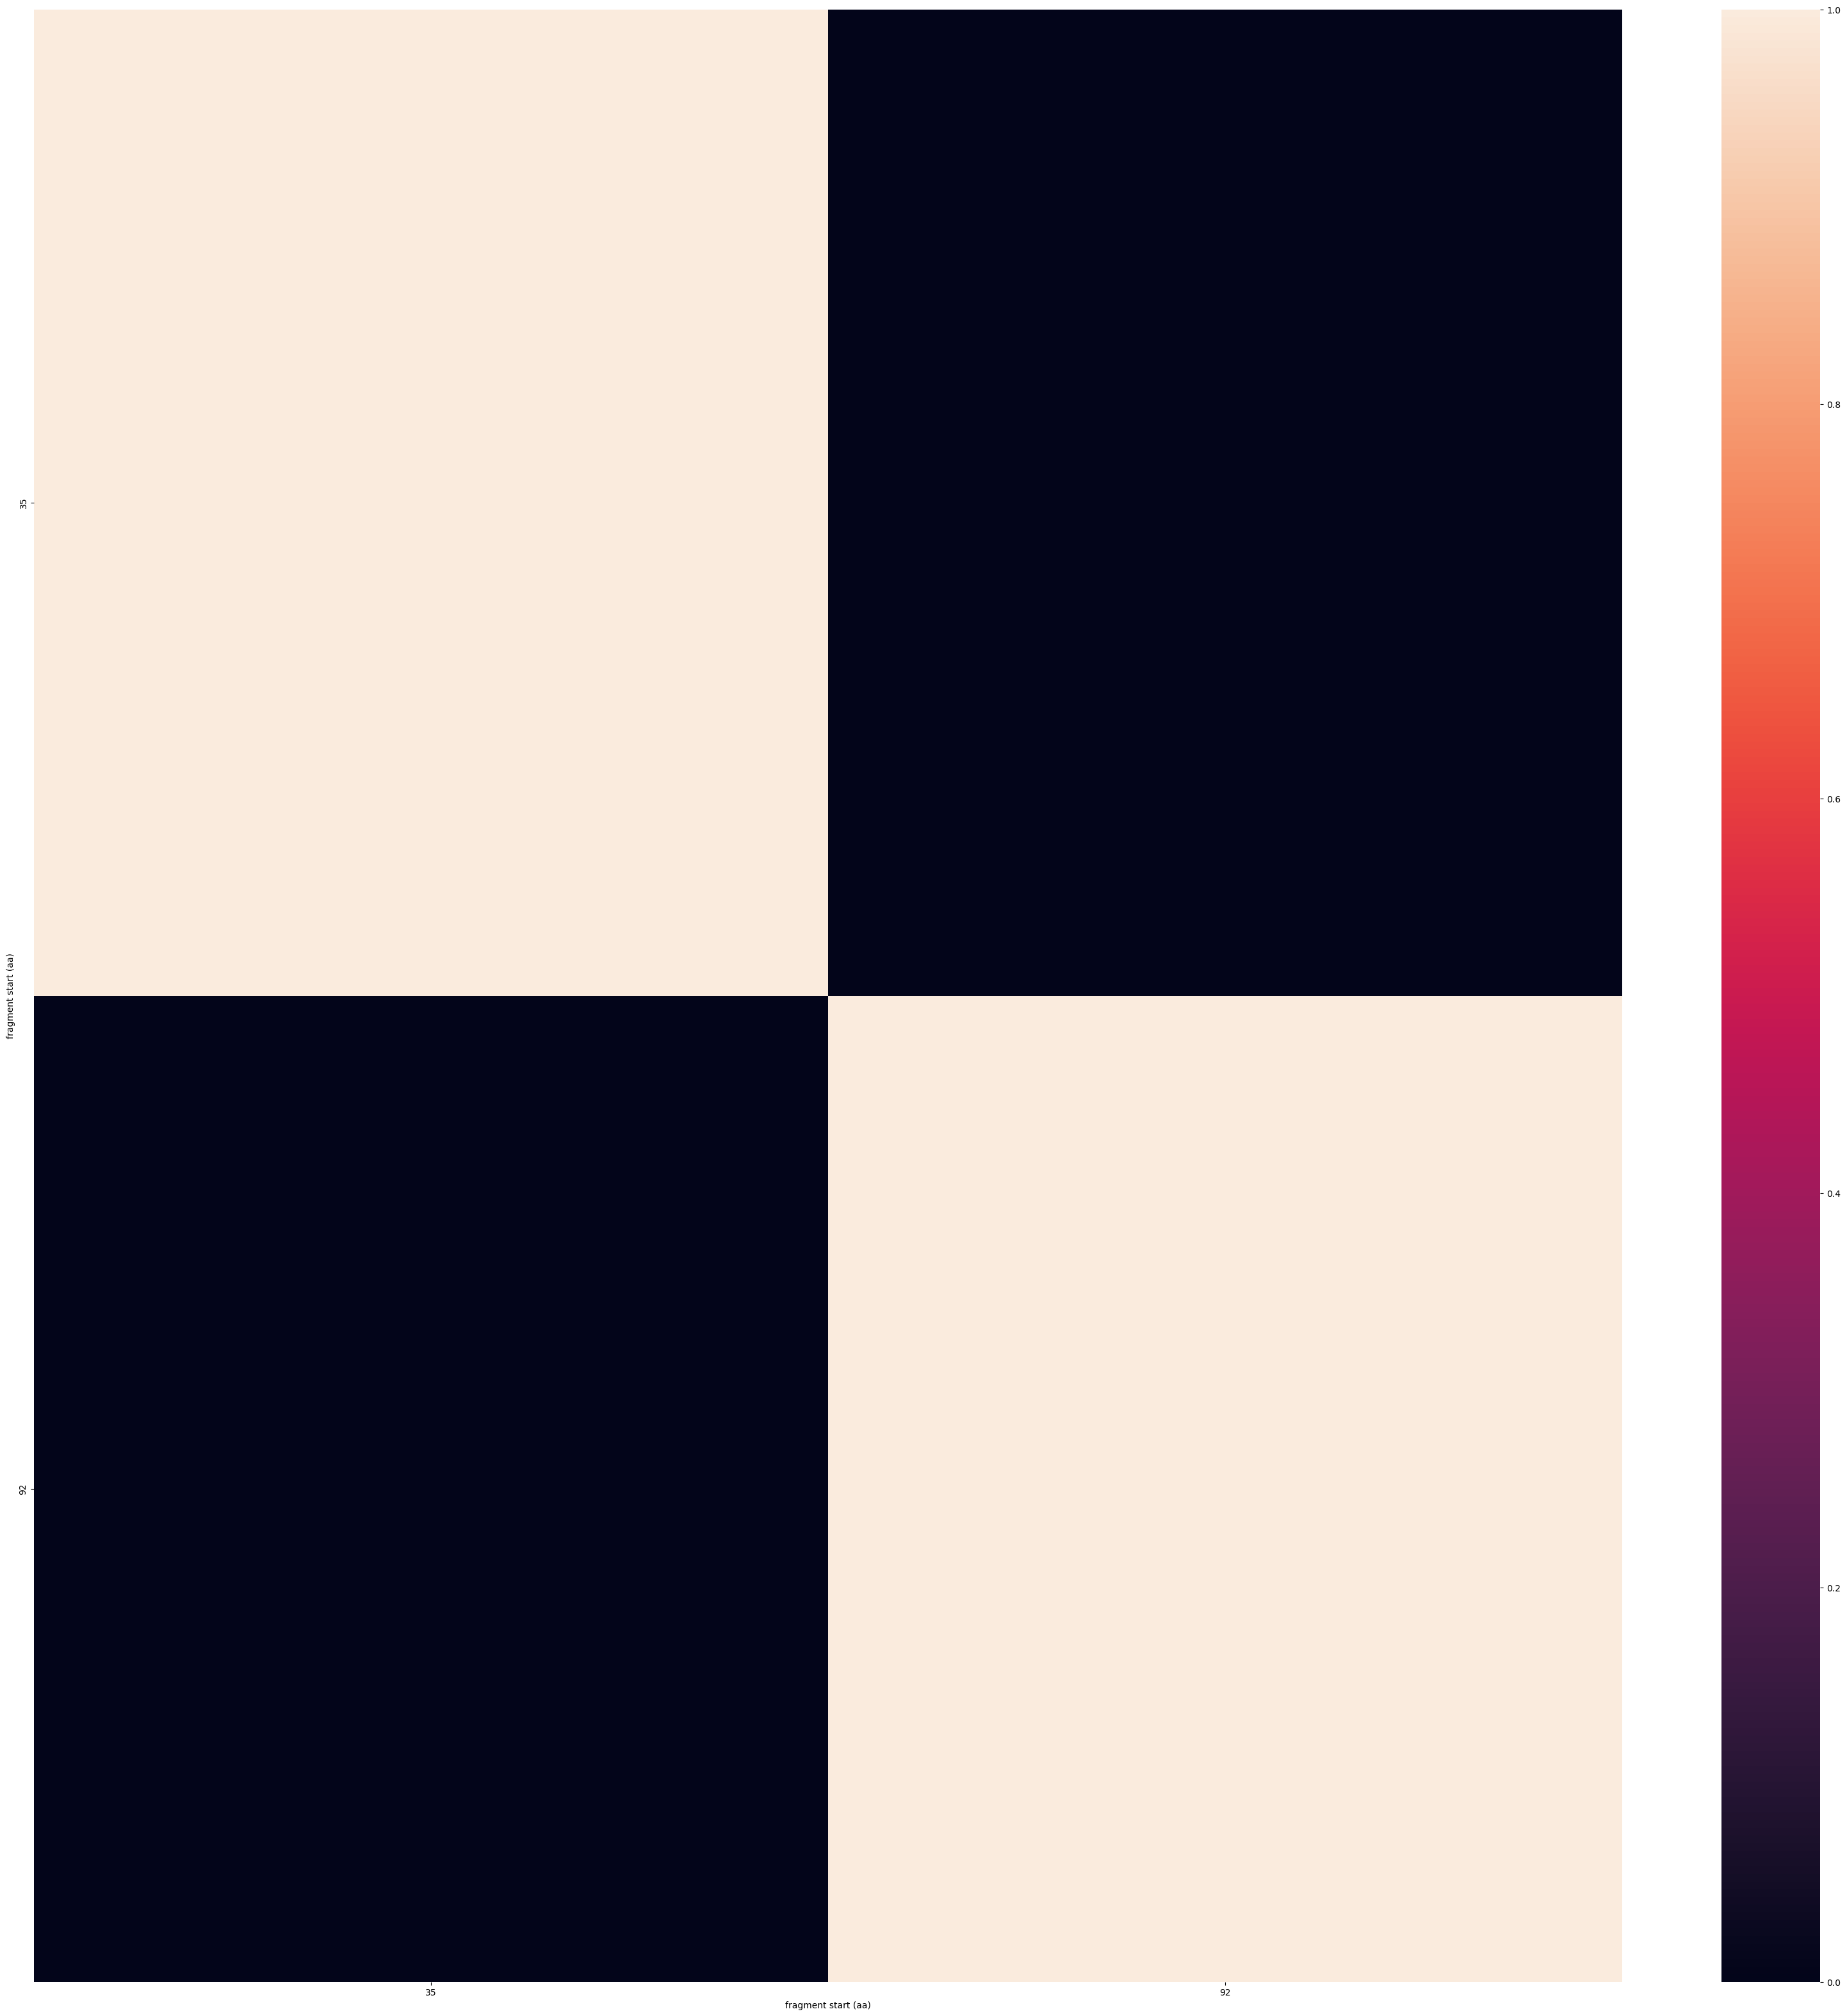

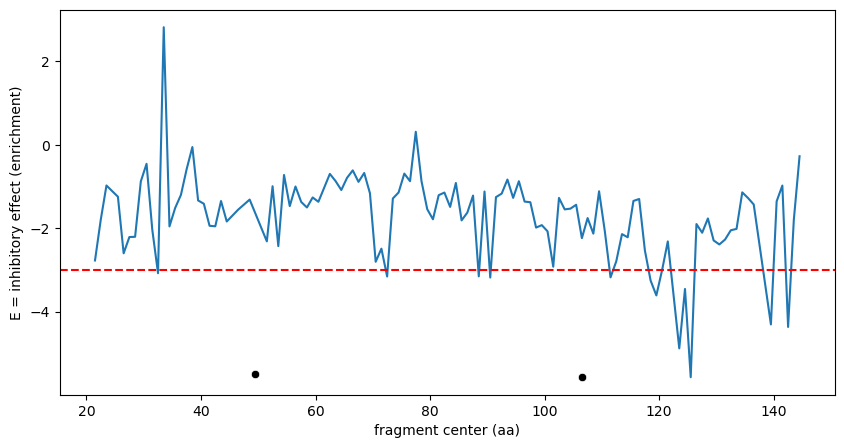

clustering 109 predictions from ftsZ-coding-EcoliBL21DE3_30aa_monomer_fstZ ...
109 fragments in 8 clusters
[7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 2 2 3 3 3 8]


<Figure size 640x480 with 0 Axes>

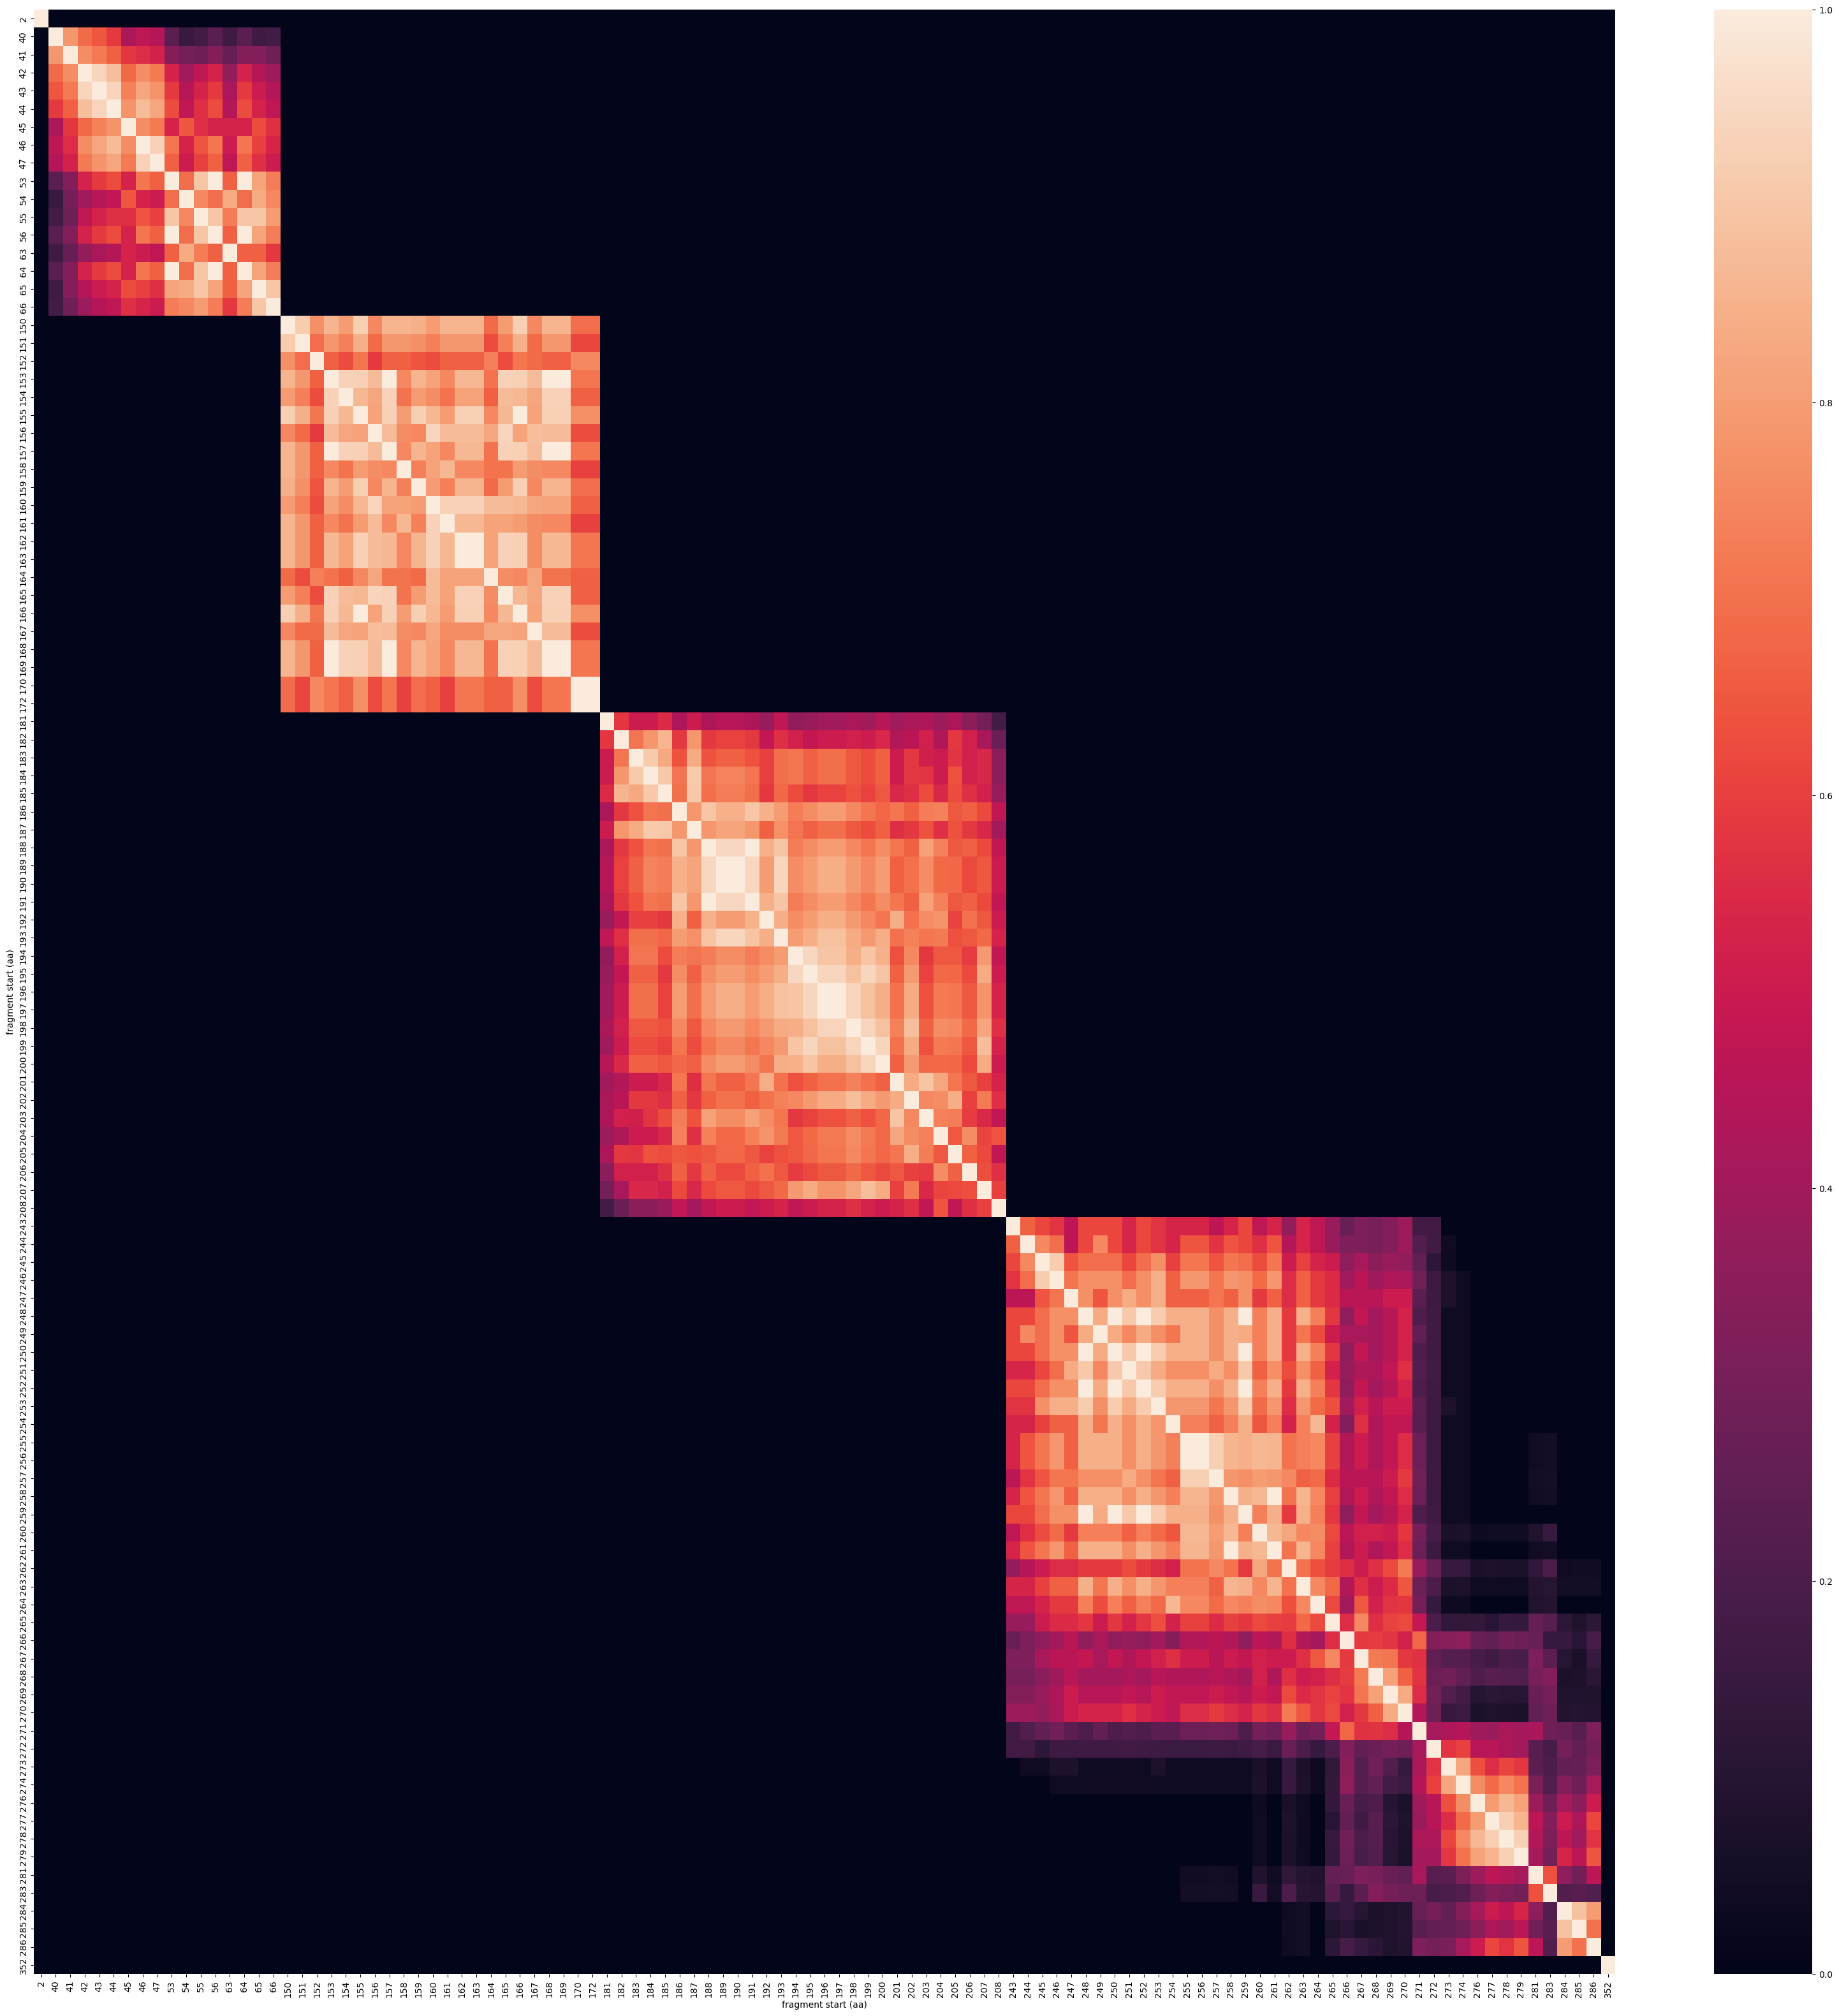

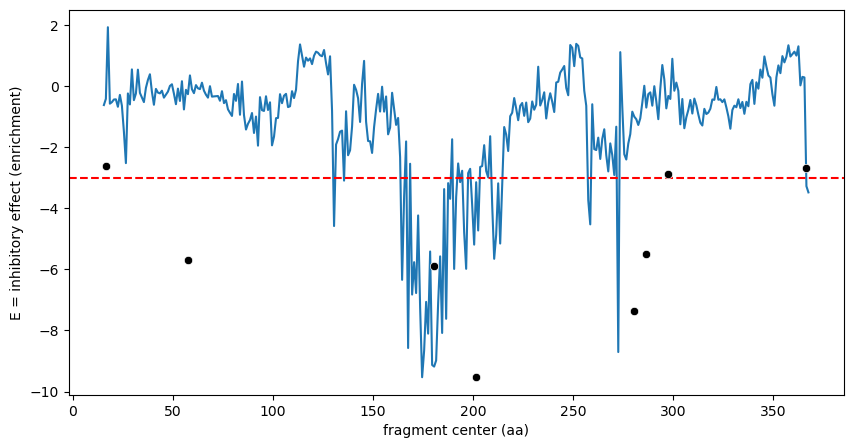

clustering 29 predictions from groL-coding-EcoliBL21DE3_30aa_dimer_groL ...
29 fragments in 29 clusters
[28 29 23 24 18 26 25 13 21 22 19 20 11  9 10  7  8 12  5  3  1  4  2  6
 17 16 14 15 27]


<Figure size 640x480 with 0 Axes>

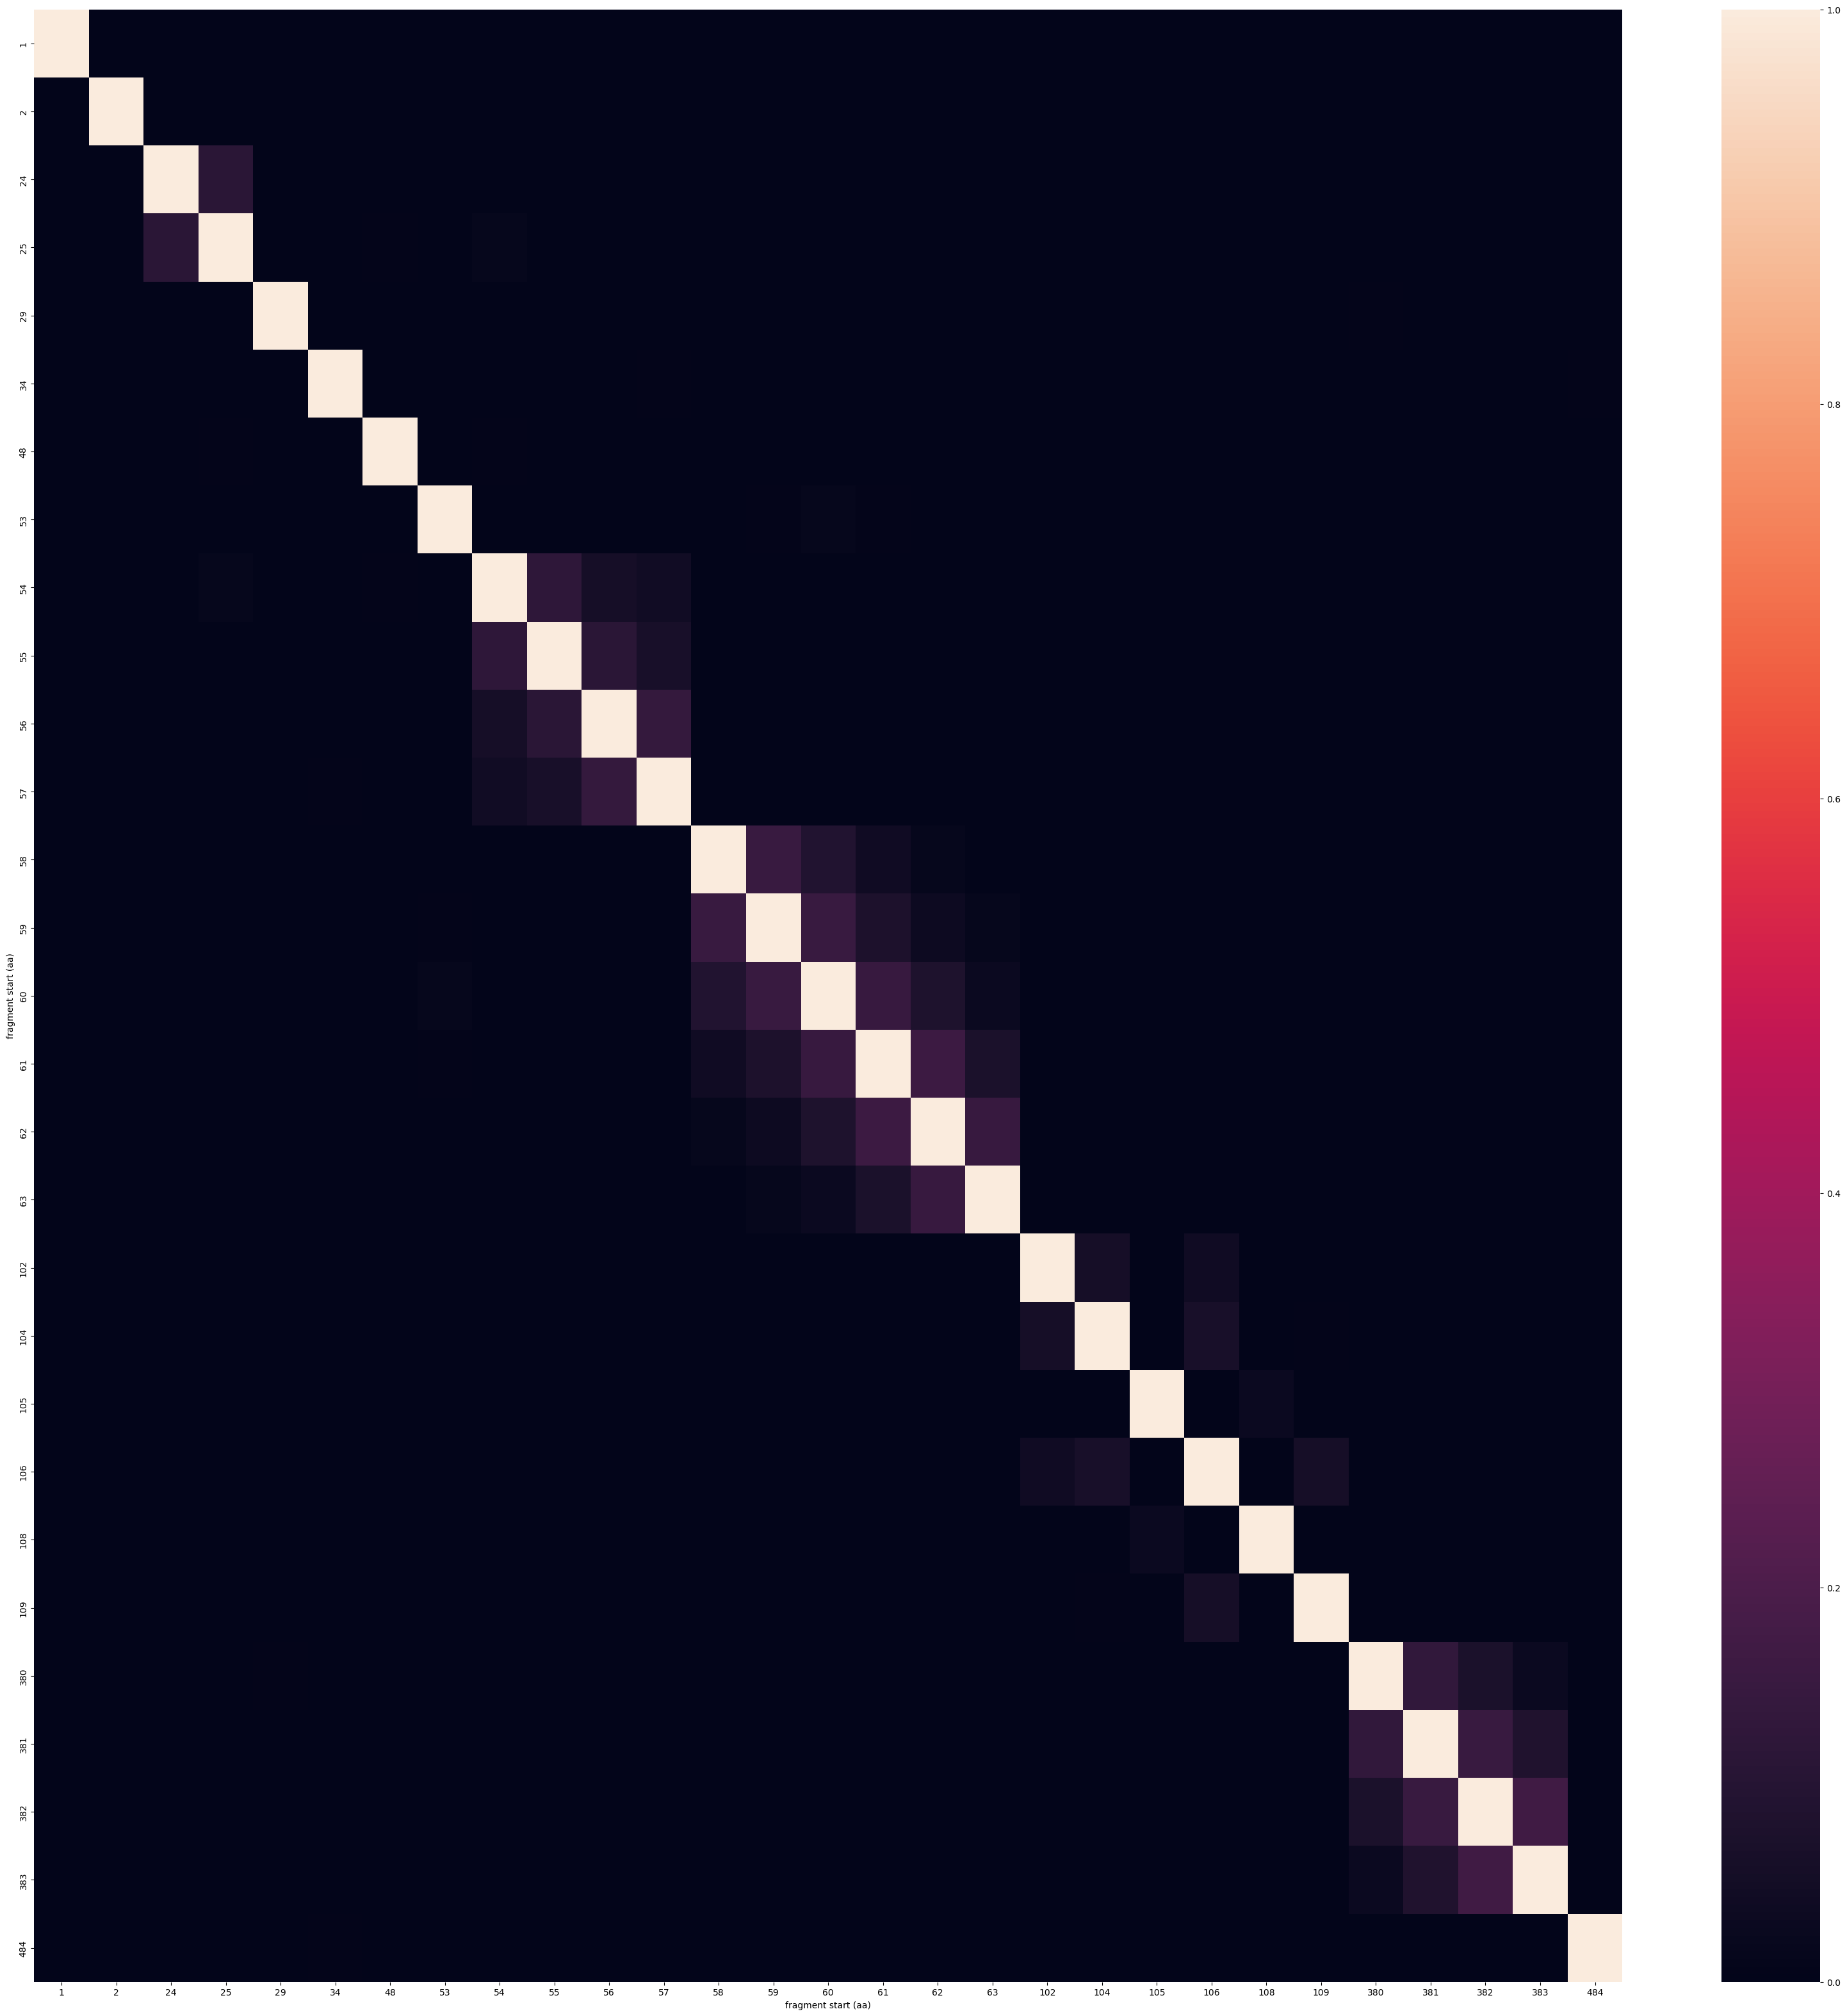

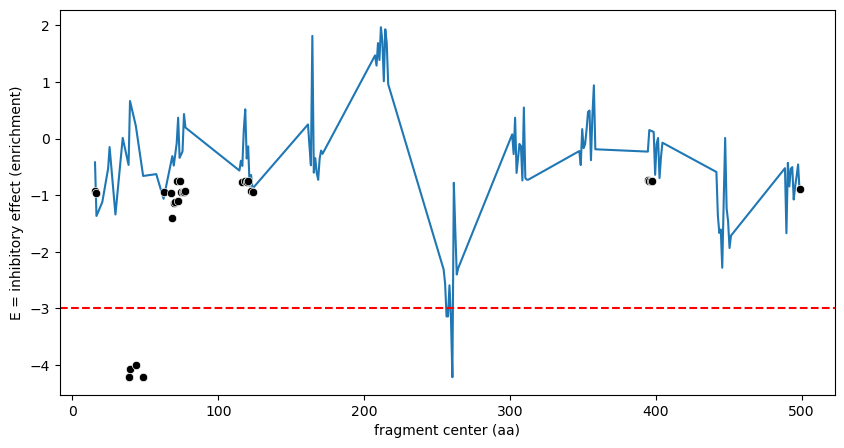

clustering 82 predictions from groL-coding-EcoliBL21DE3_30aa_monomer_groL ...
82 fragments in 6 clusters
[5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 4 6 4
 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


<Figure size 640x480 with 0 Axes>

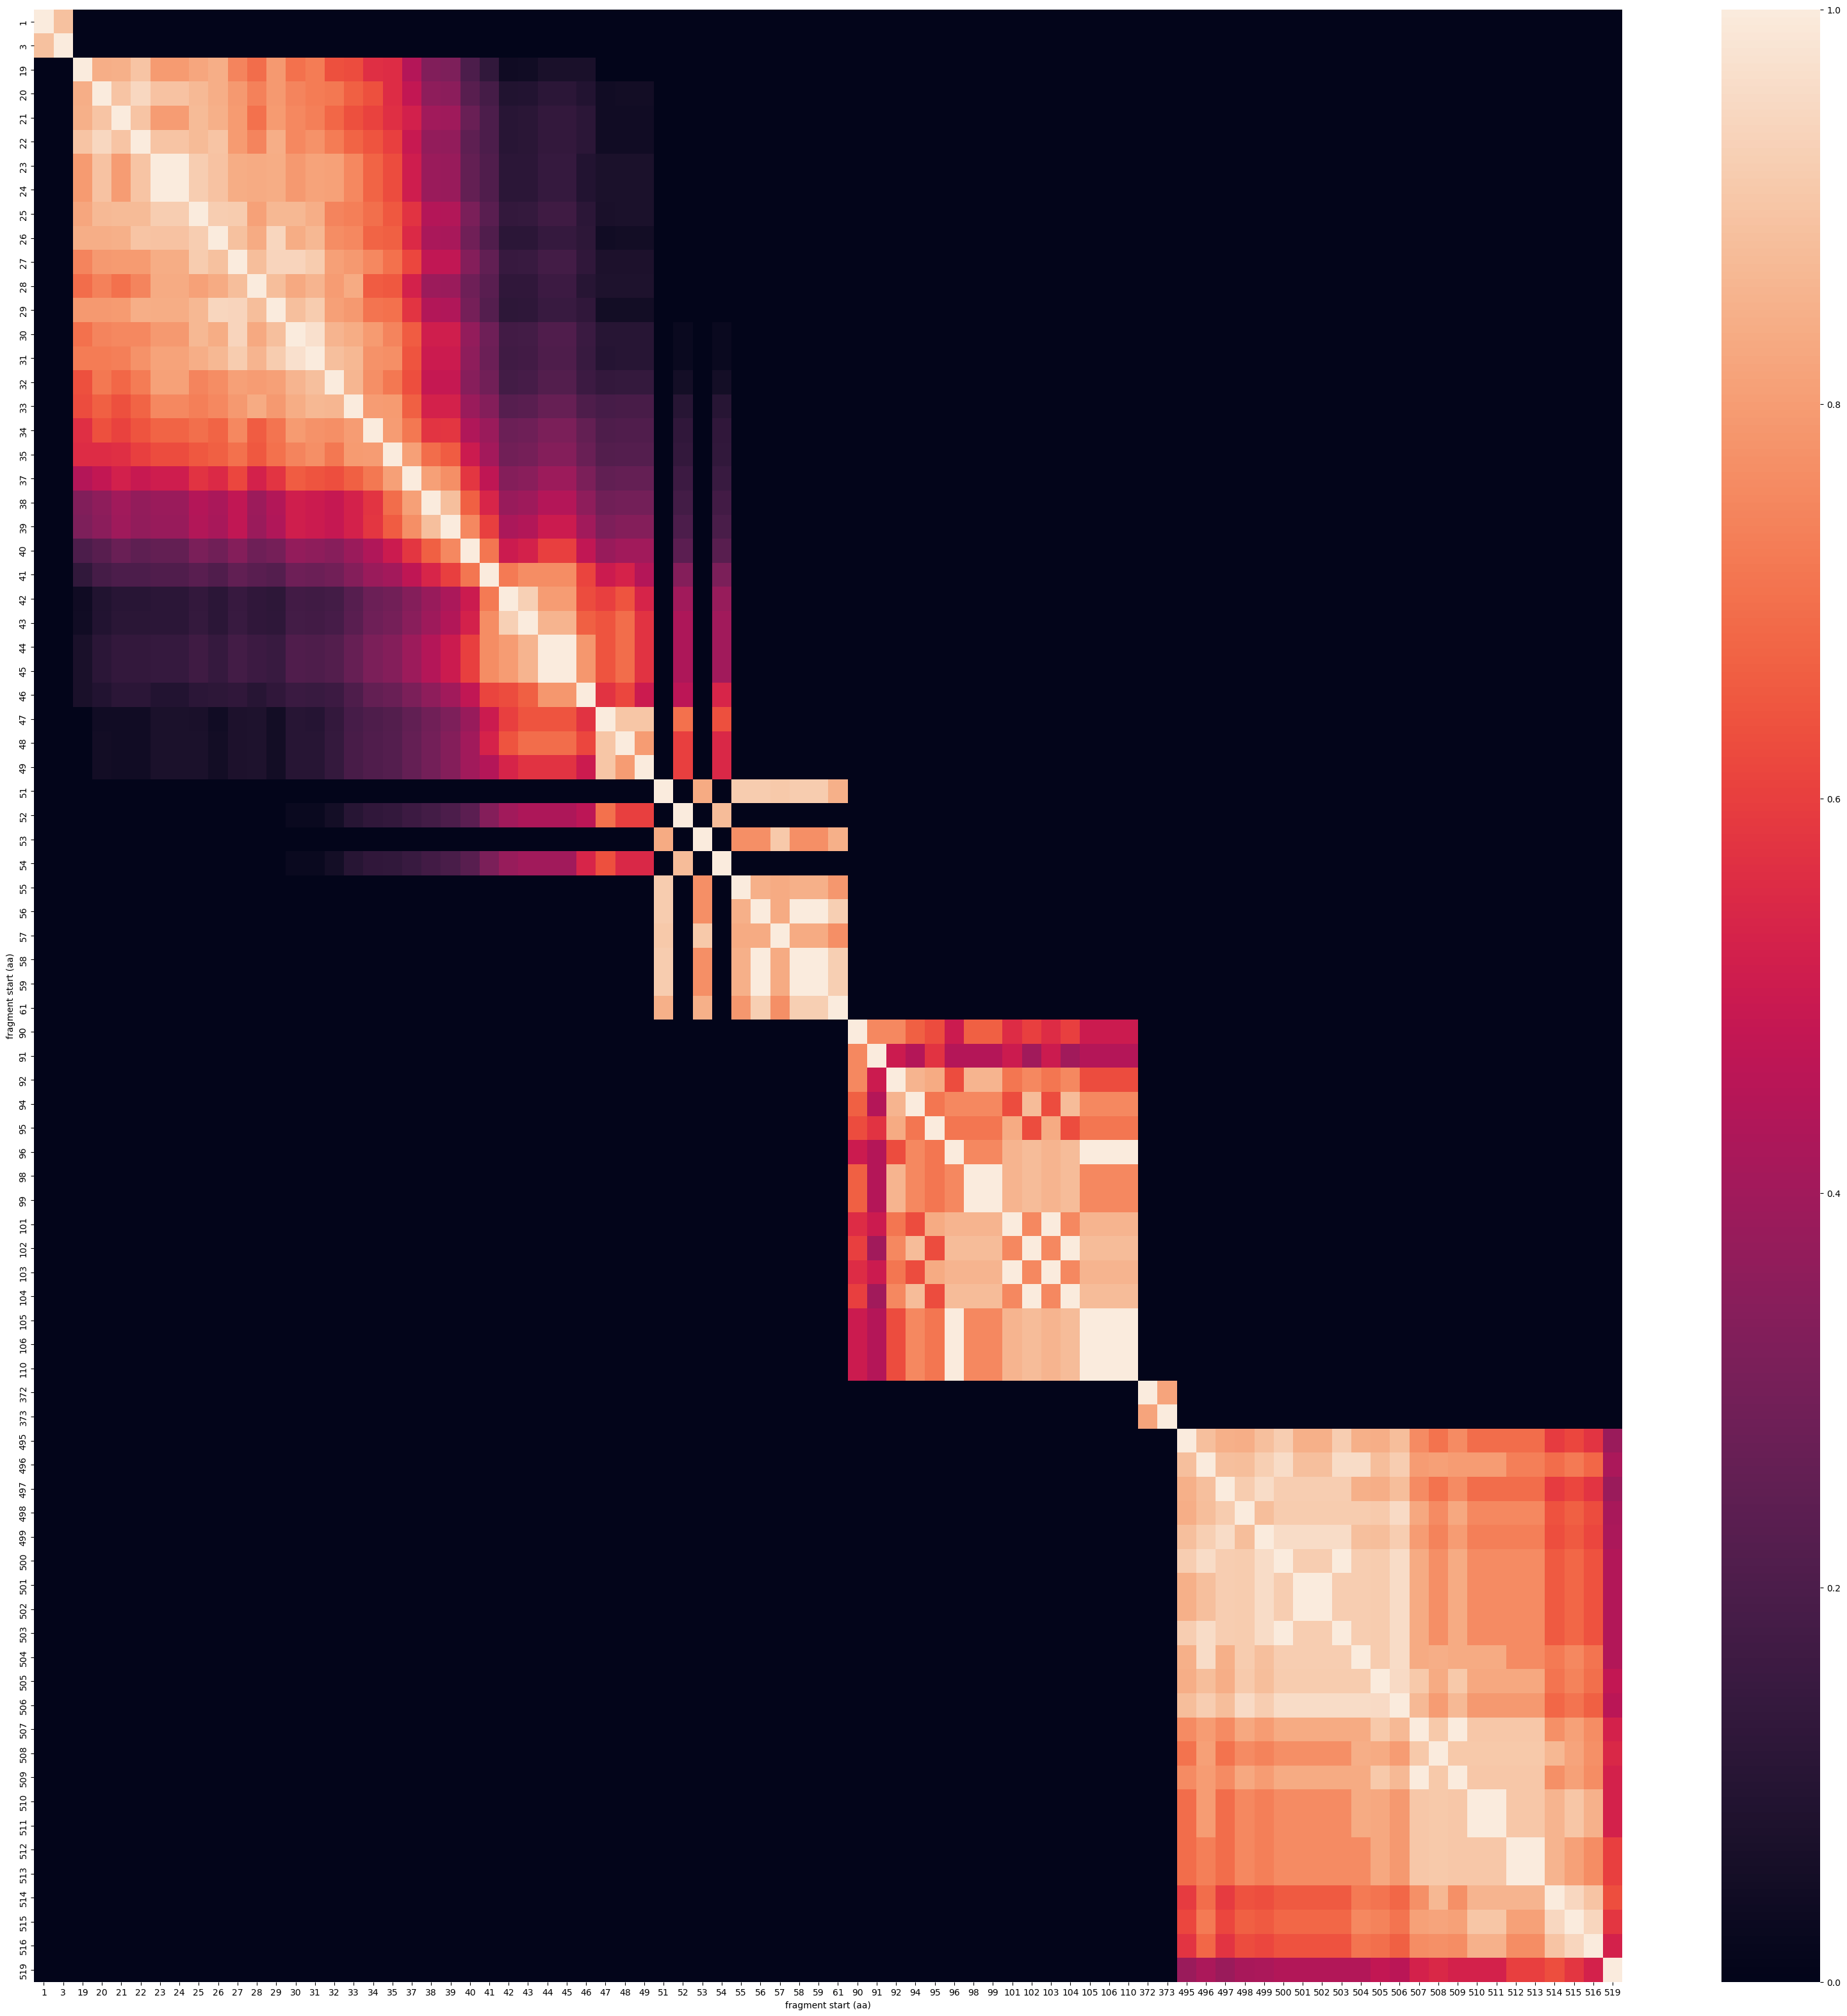

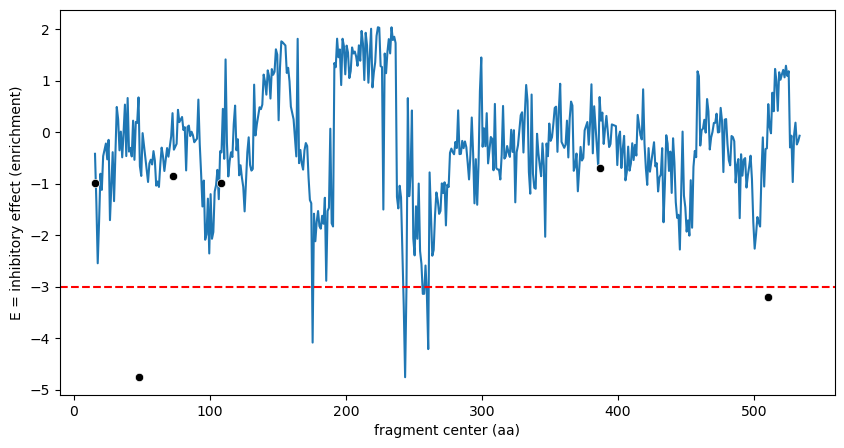

clustering 9 predictions from groL-coding-EcoliBL21DE3_30aa_monomer_groS ...
9 fragments in 3 clusters
[2 1 1 1 1 1 1 1 3]


<Figure size 640x480 with 0 Axes>

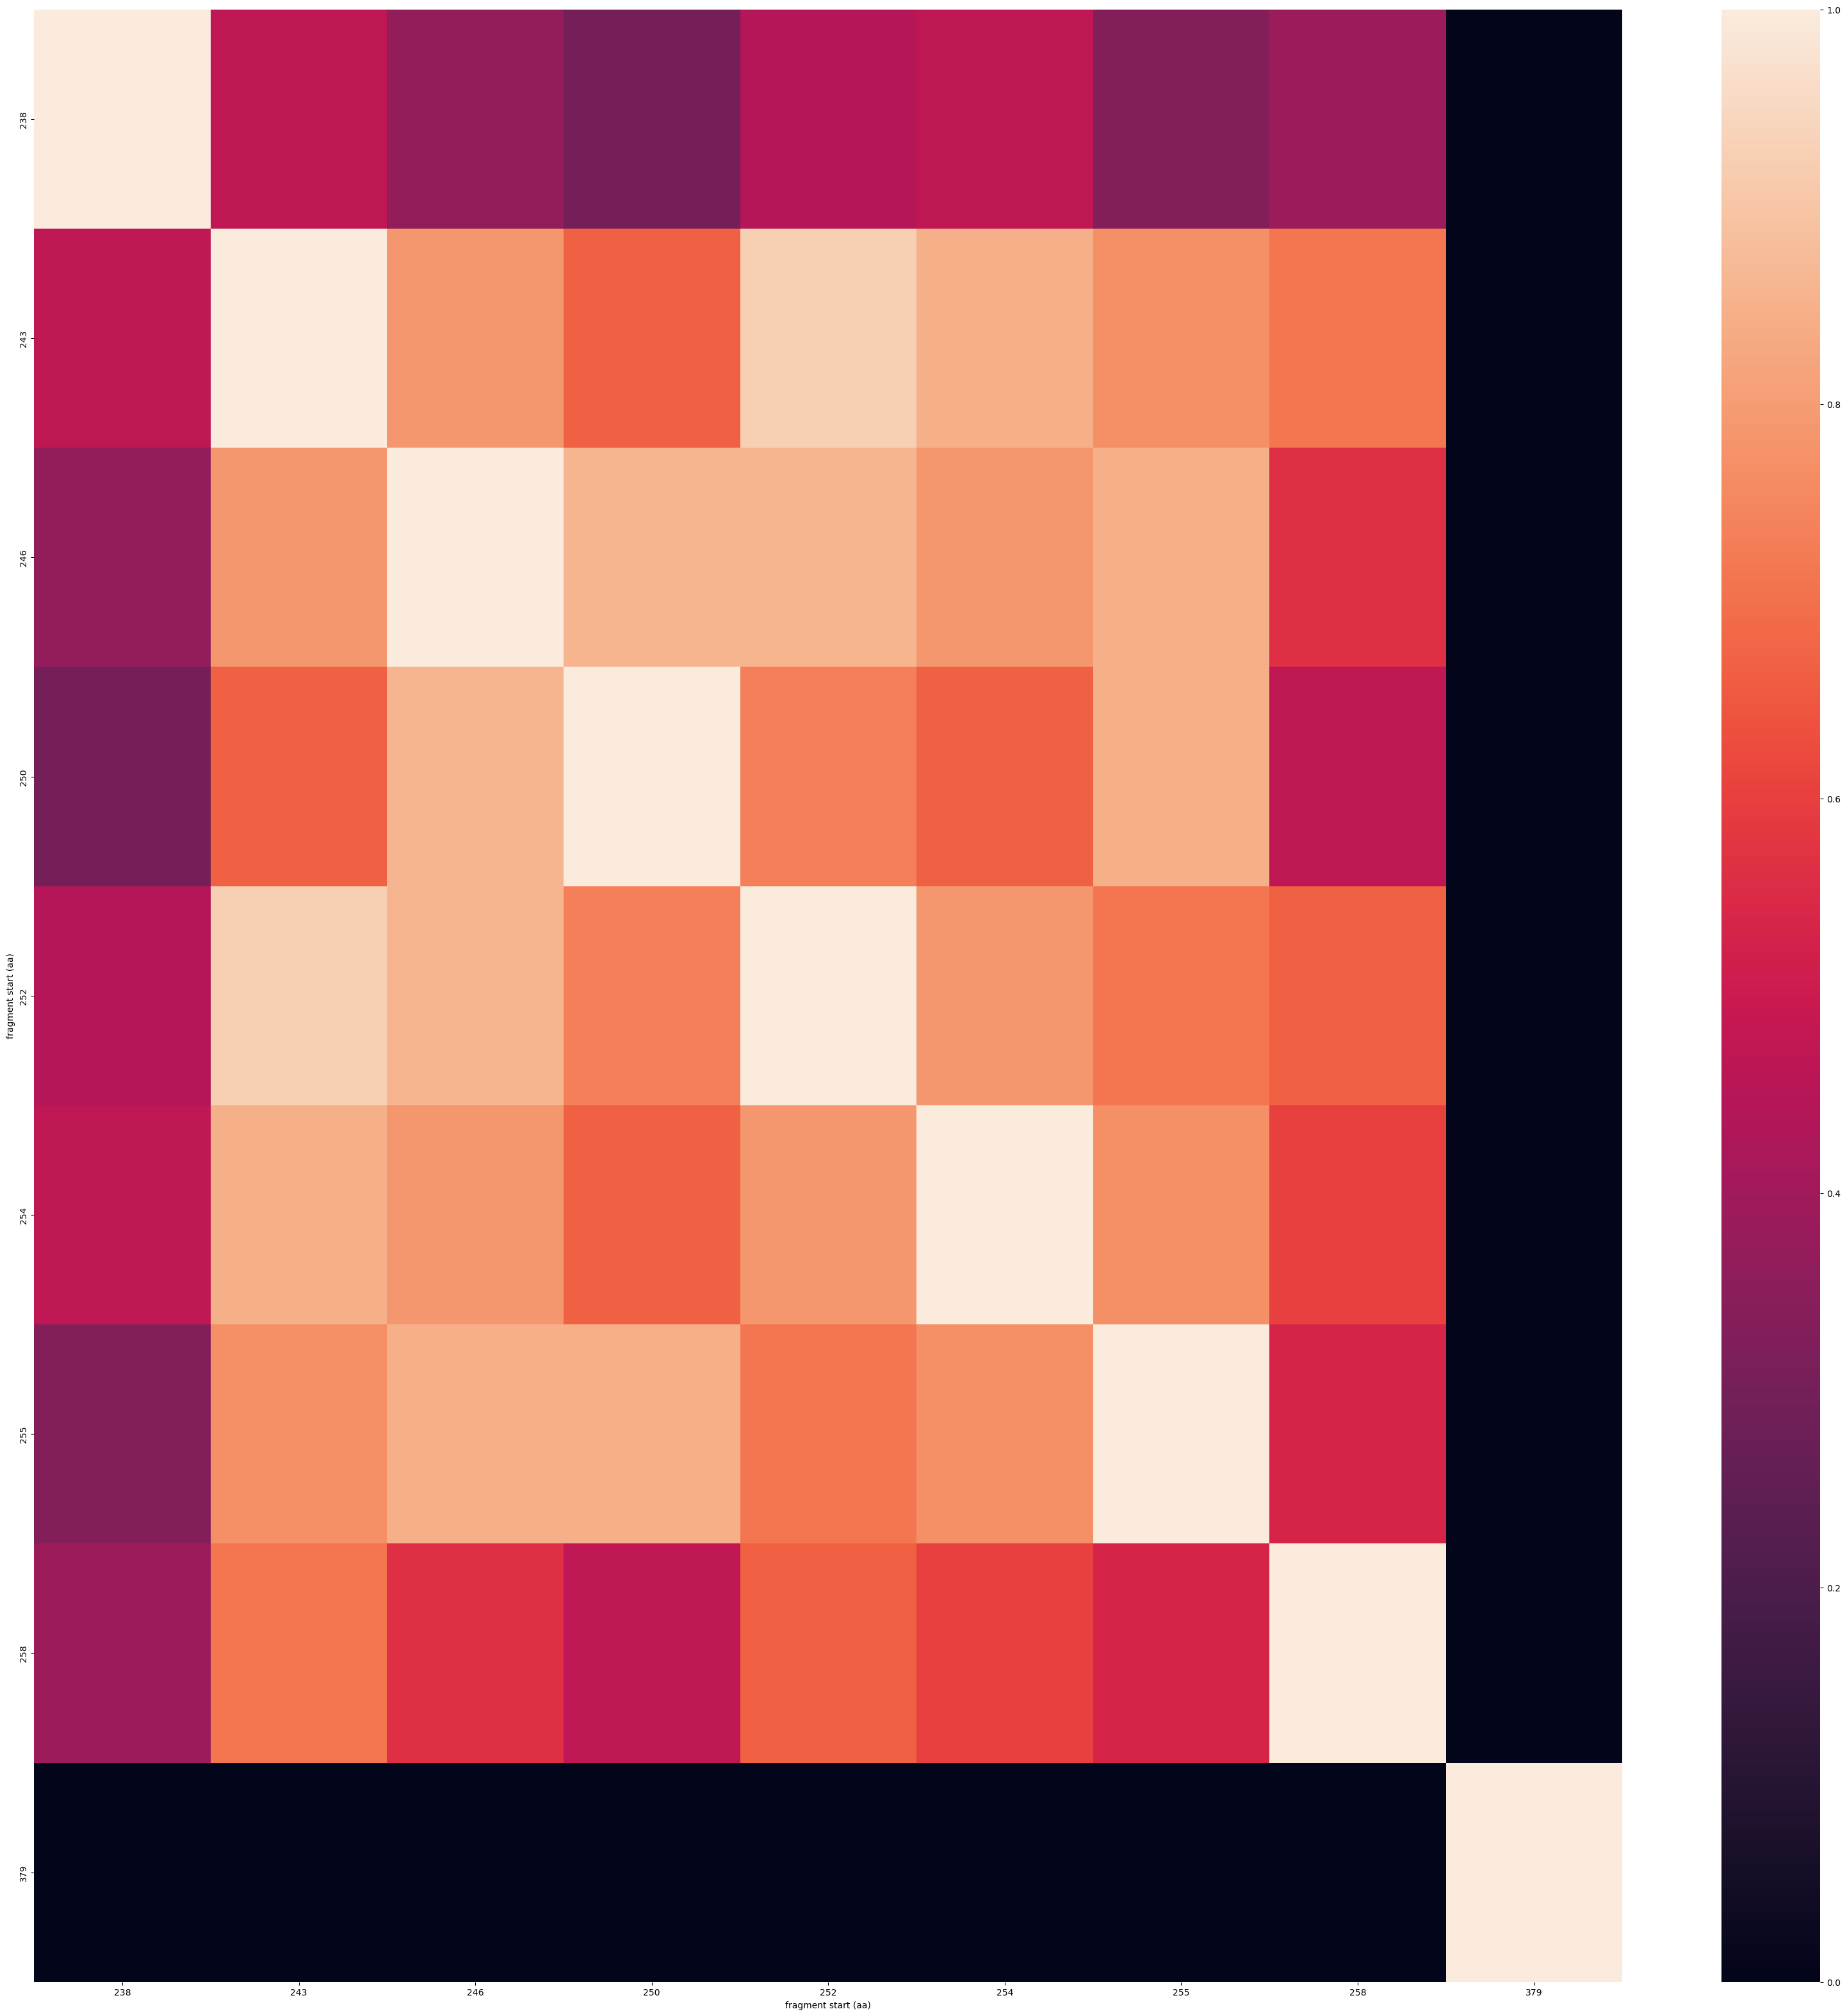

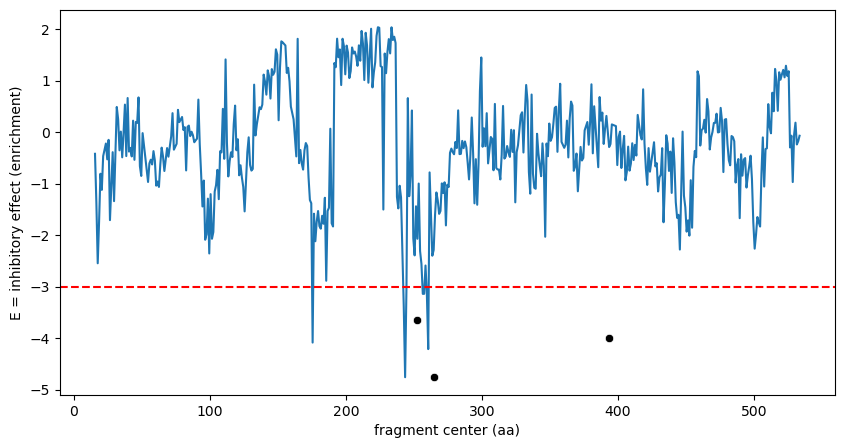

clustering 104 predictions from gyrA-coding-EcoliBL21DE3_30aa_monomer_gyrA ...
104 fragments in 10 clusters
[ 9  9  9  8  9  9  9  9  9  9  9  9  9  9  9  8  9  9  8  9  9  8  8  9
  9  9  9  9  9  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  2  2  2  2  2  2  2  2  2
  2  2  3  1  5  1  4 10]


<Figure size 640x480 with 0 Axes>

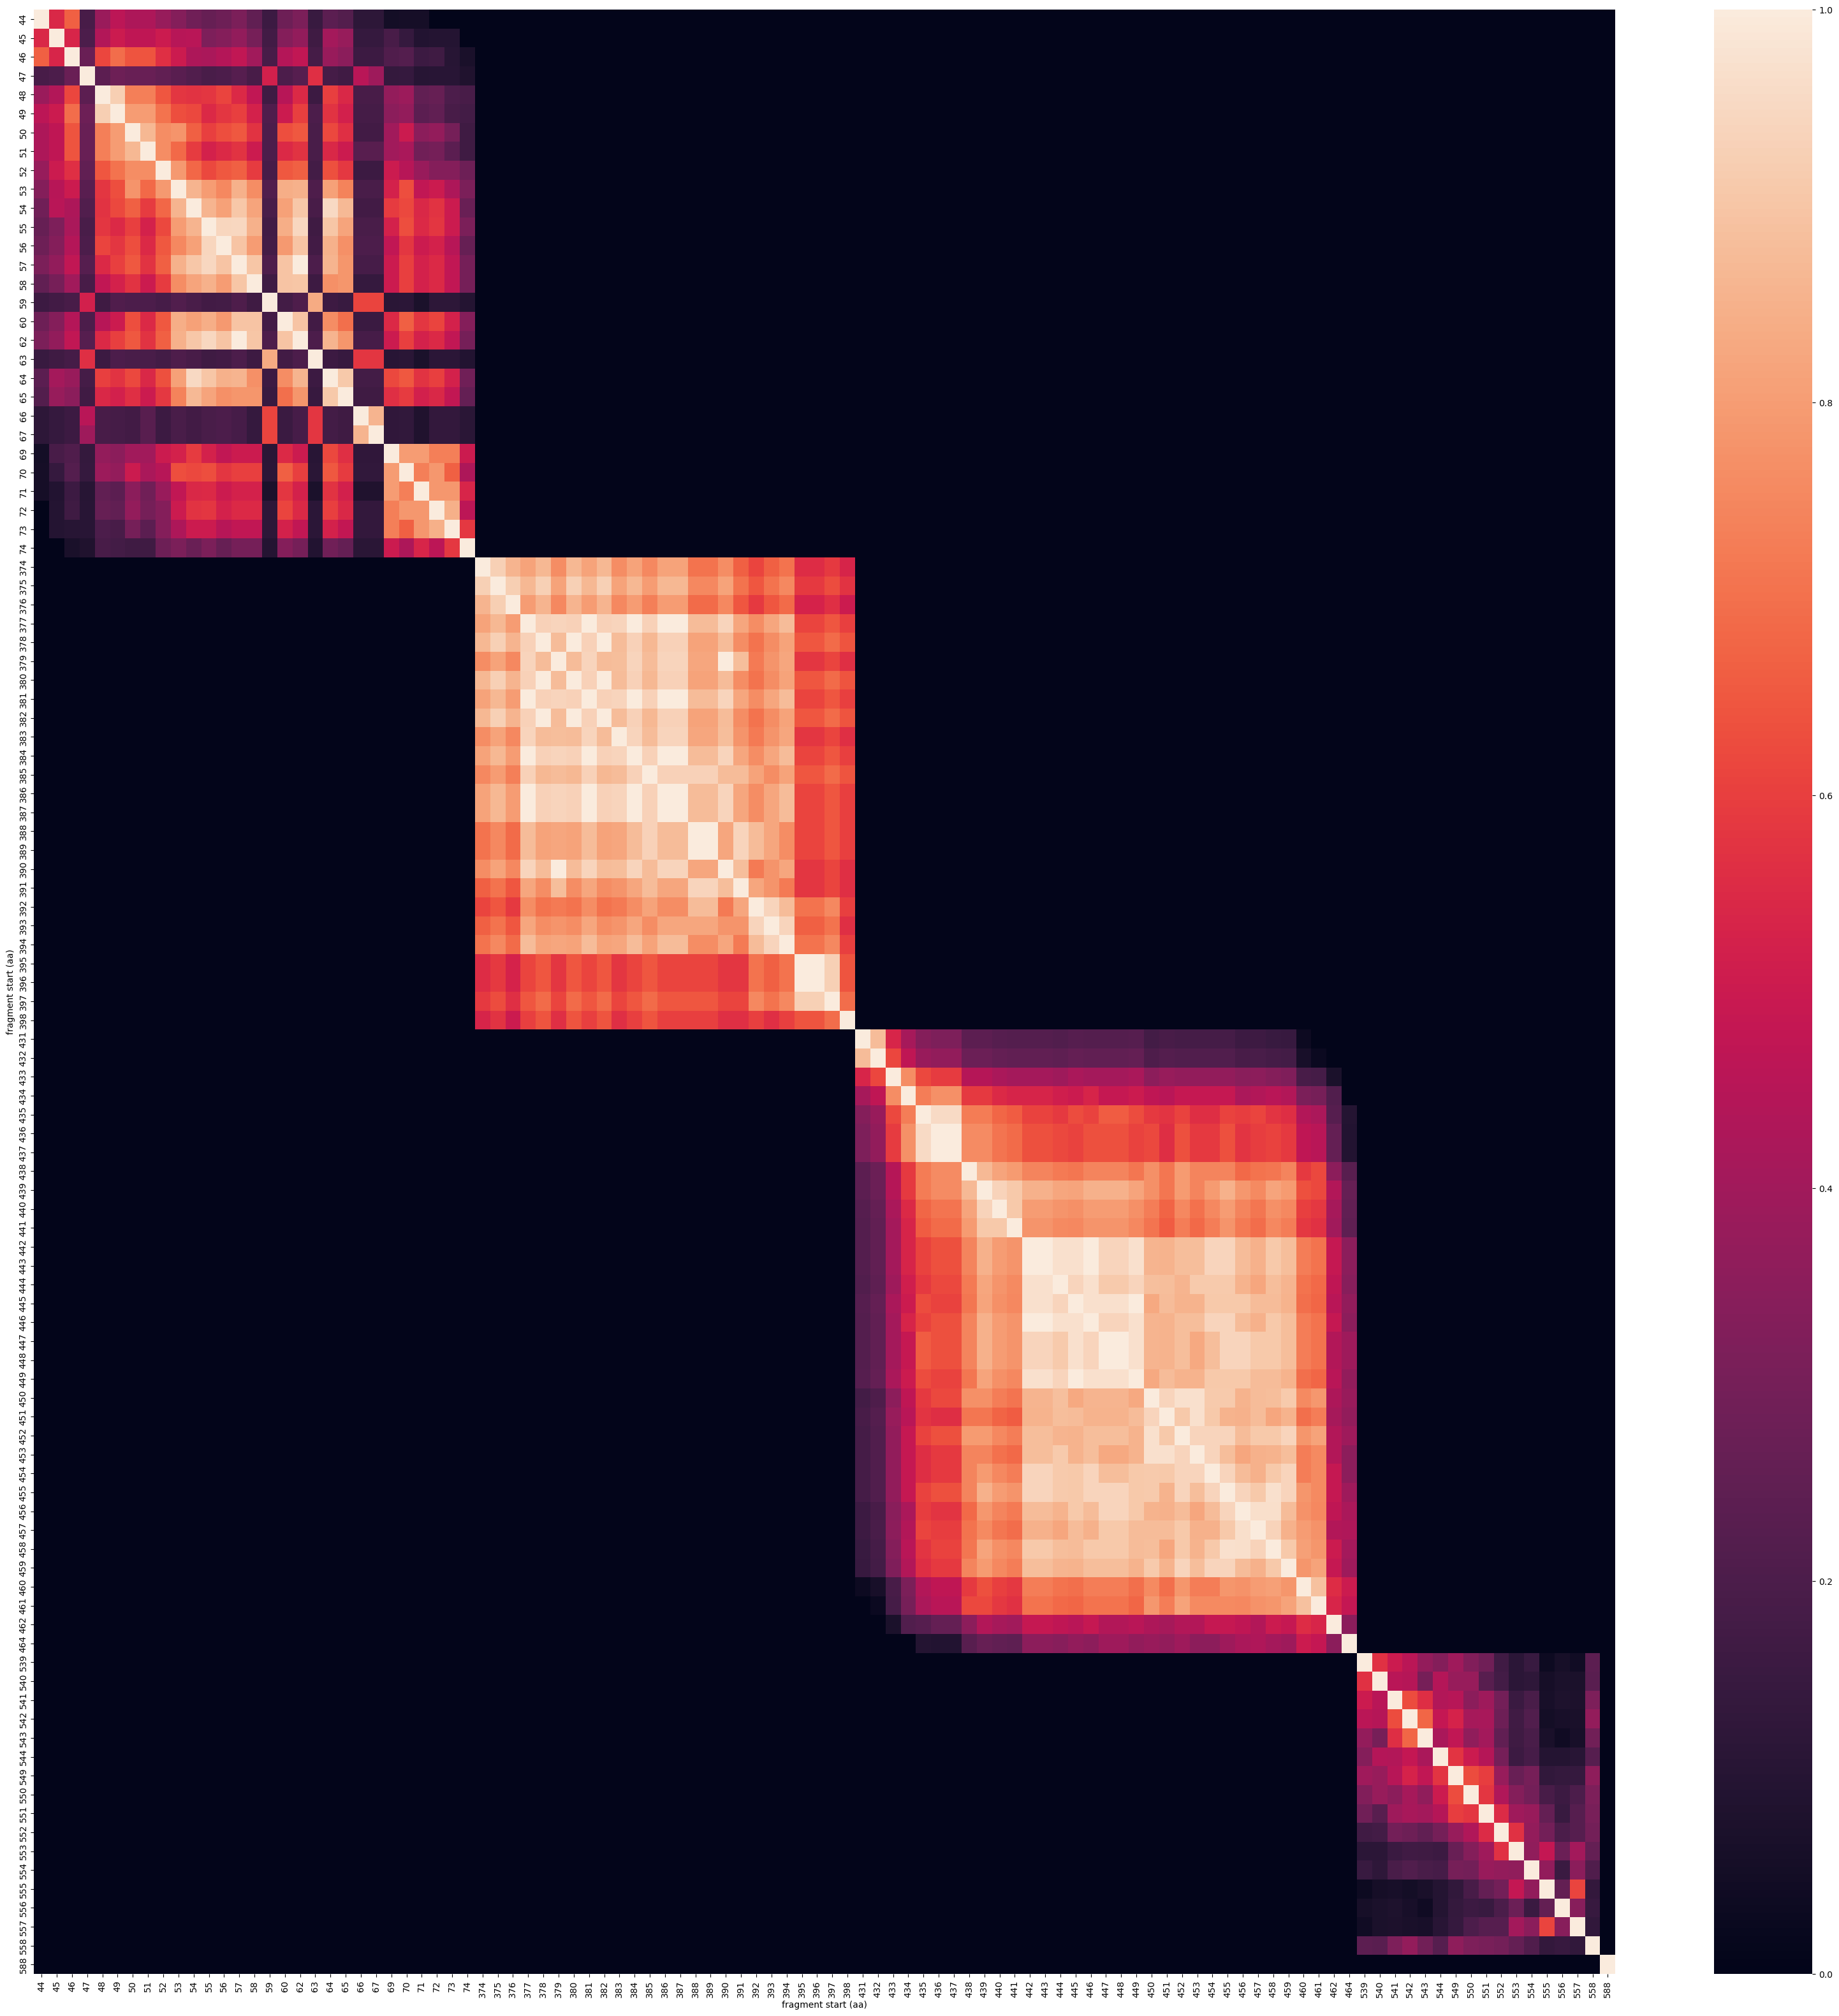

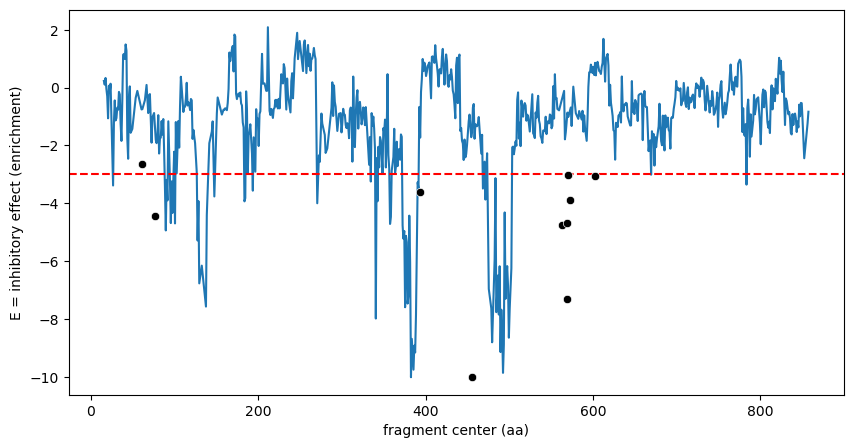

clustering 89 predictions from gyrA-coding-EcoliBL21DE3_30aa_monomer_gyrB ...
89 fragments in 33 clusters
[23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 25 20 22
 21 18 19 26 27 28 16 29 17 30  9  9  9  9  9  9 10 10 10 10 11 15 14 13
 13 13 13 12 12 31  8  8  8  8  6  5  5 32  7  4  4  3  3  3  3  3  3  3
  3  3  3  3  3  3  1  1  1  1  1  1  1  1  1  2 33]


<Figure size 640x480 with 0 Axes>

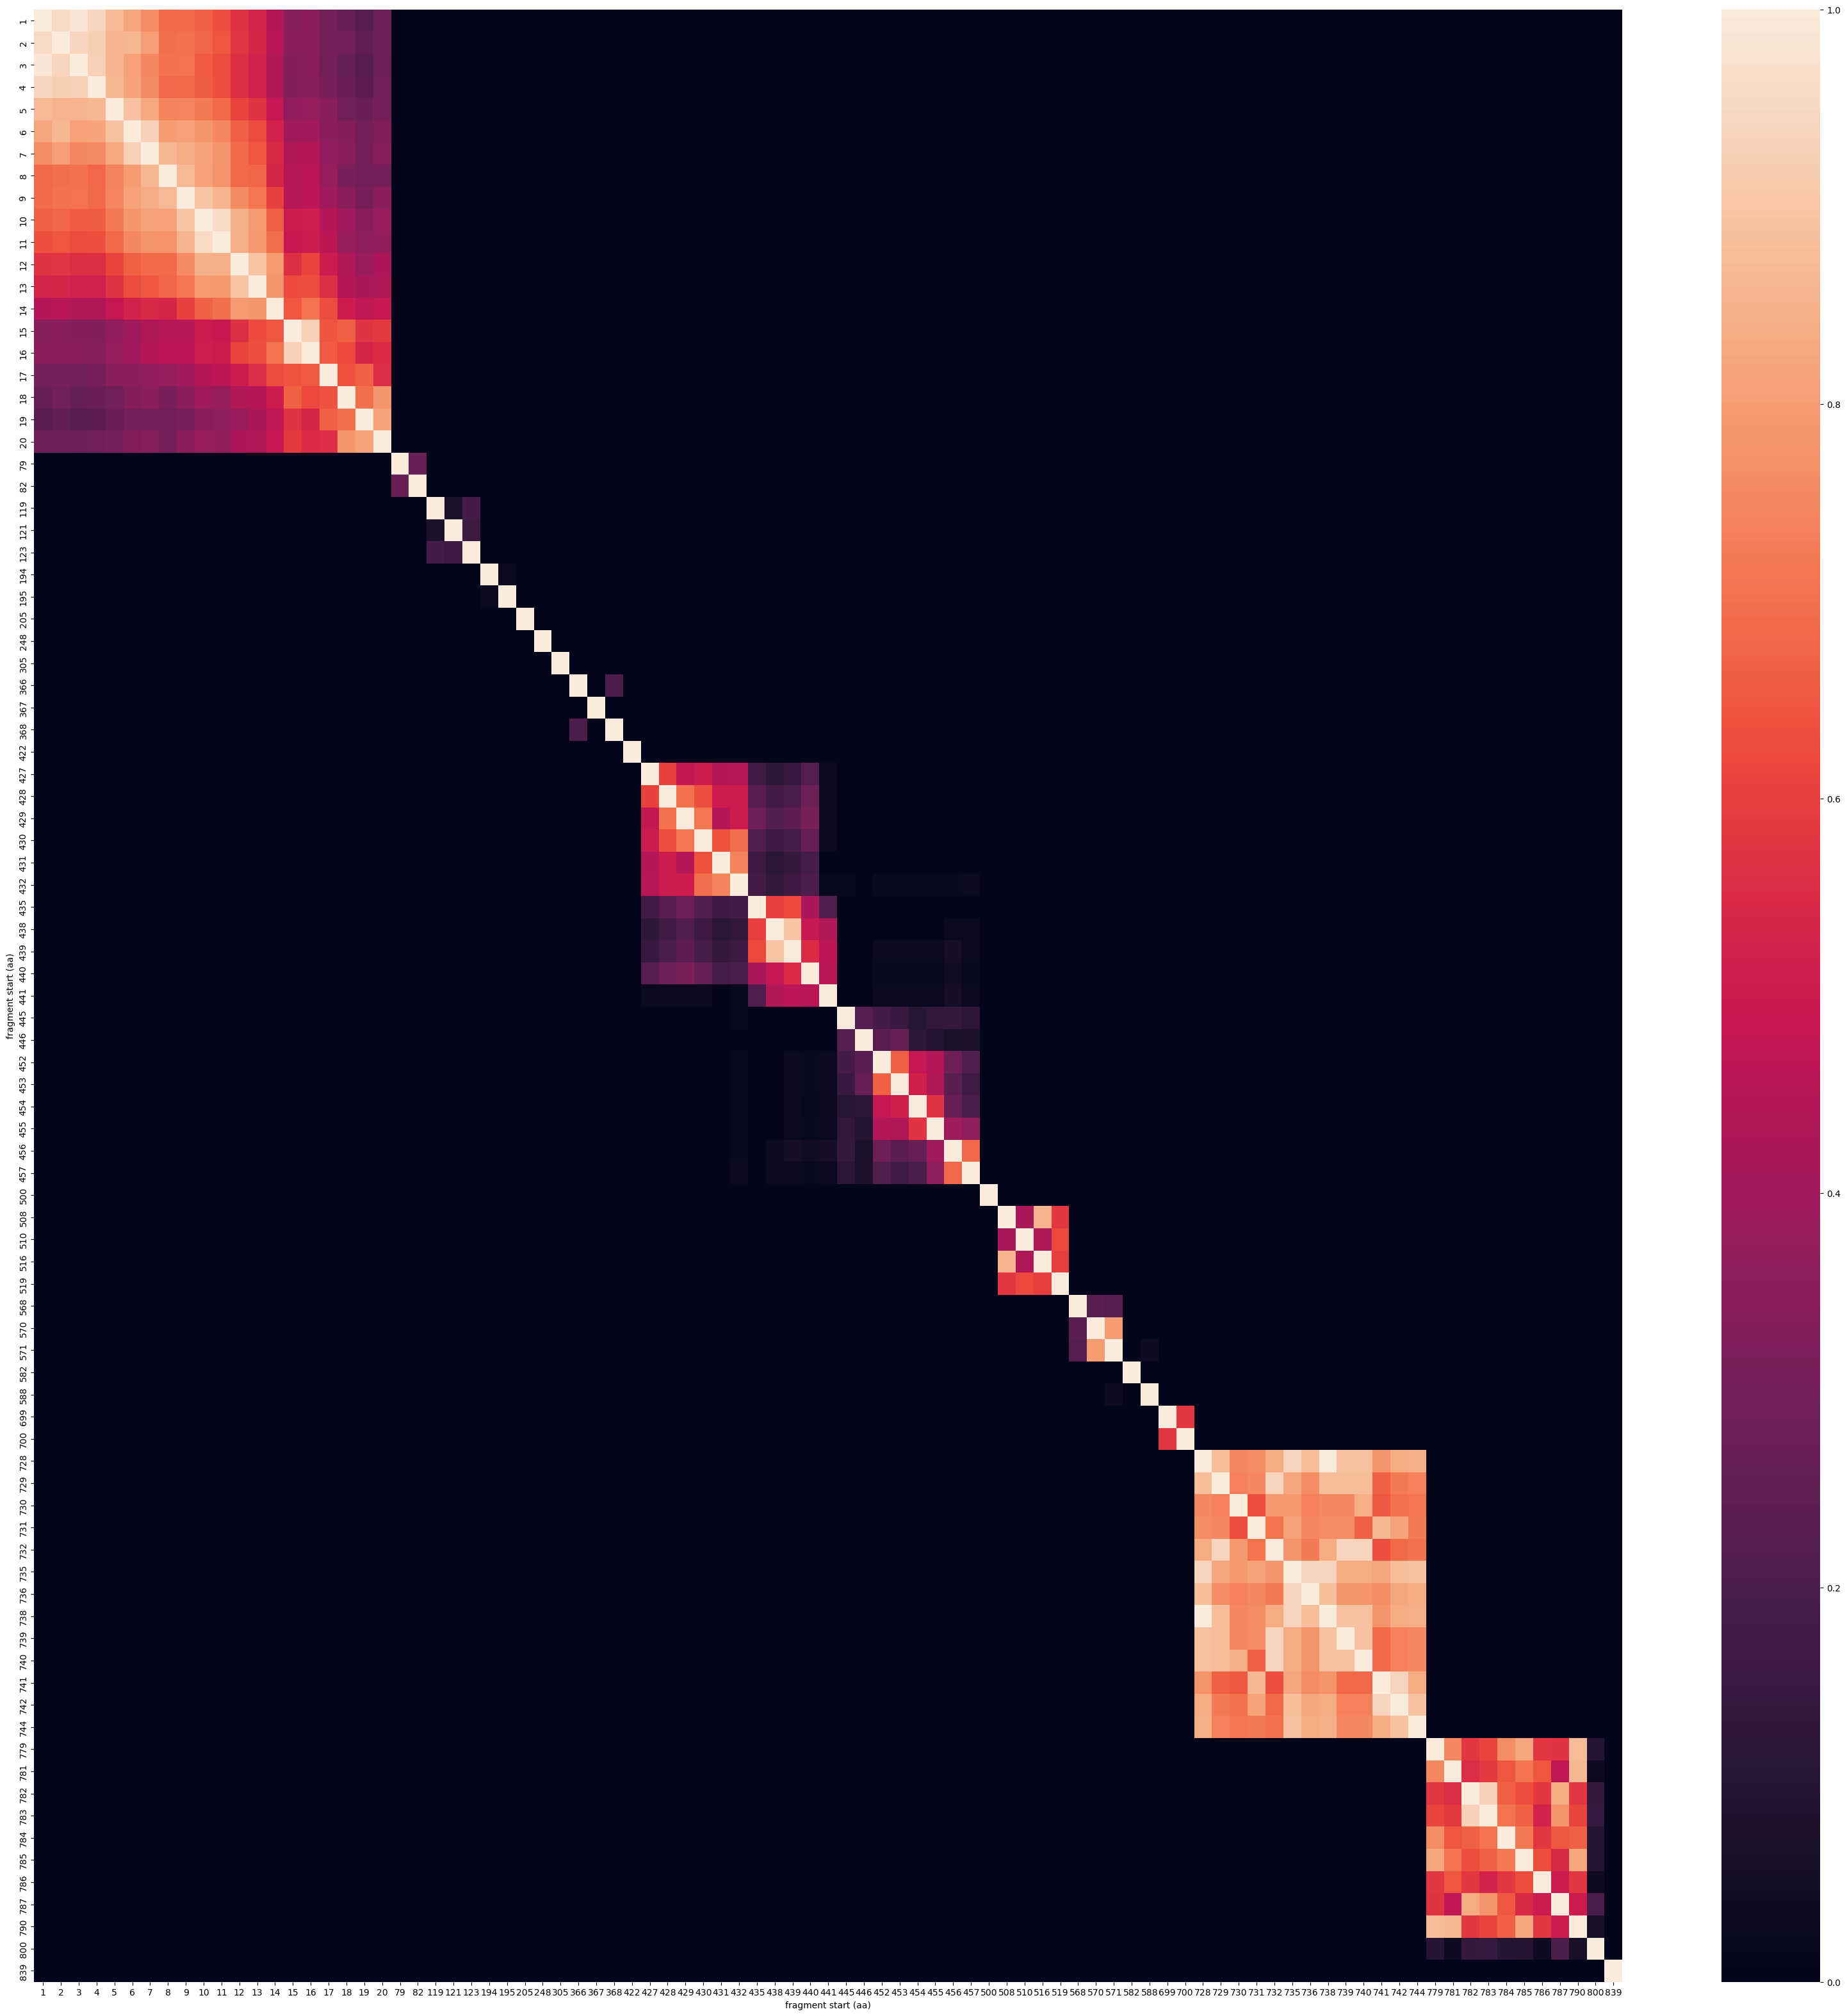

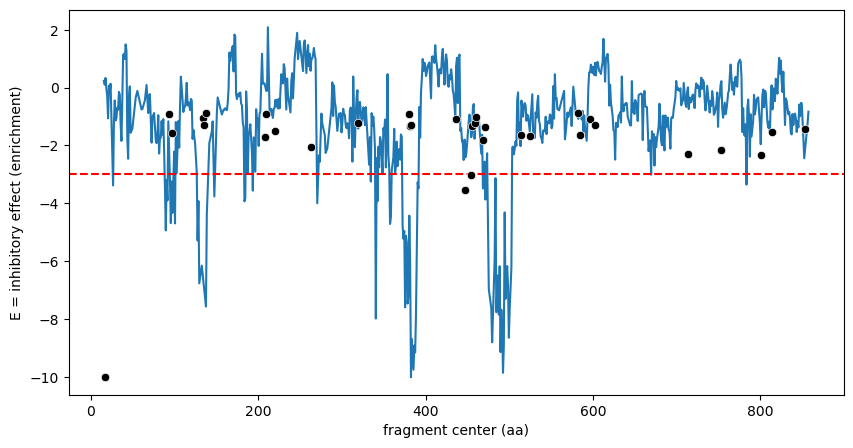

clustering 79 predictions from lptG-coding-EcoliBL21DE3_30aa_monomer_lptF ...
79 fragments in 37 clusters
[24 27 24 25 25 26 26 26 26 26 26 23 22 22 22 22 22 22 22 22 28 28 29 30
 31 32 33 20 19 17 21 18 15 15 15 16 34 16 14 14 14 14 14 14 14 35 12 12
 12 12 12 12 12 12 13 13 13 13 11  9 10  8  8  4  4  5  6  7 36 37  3  3
  3  3  2  2  1  1  1]


<Figure size 640x480 with 0 Axes>

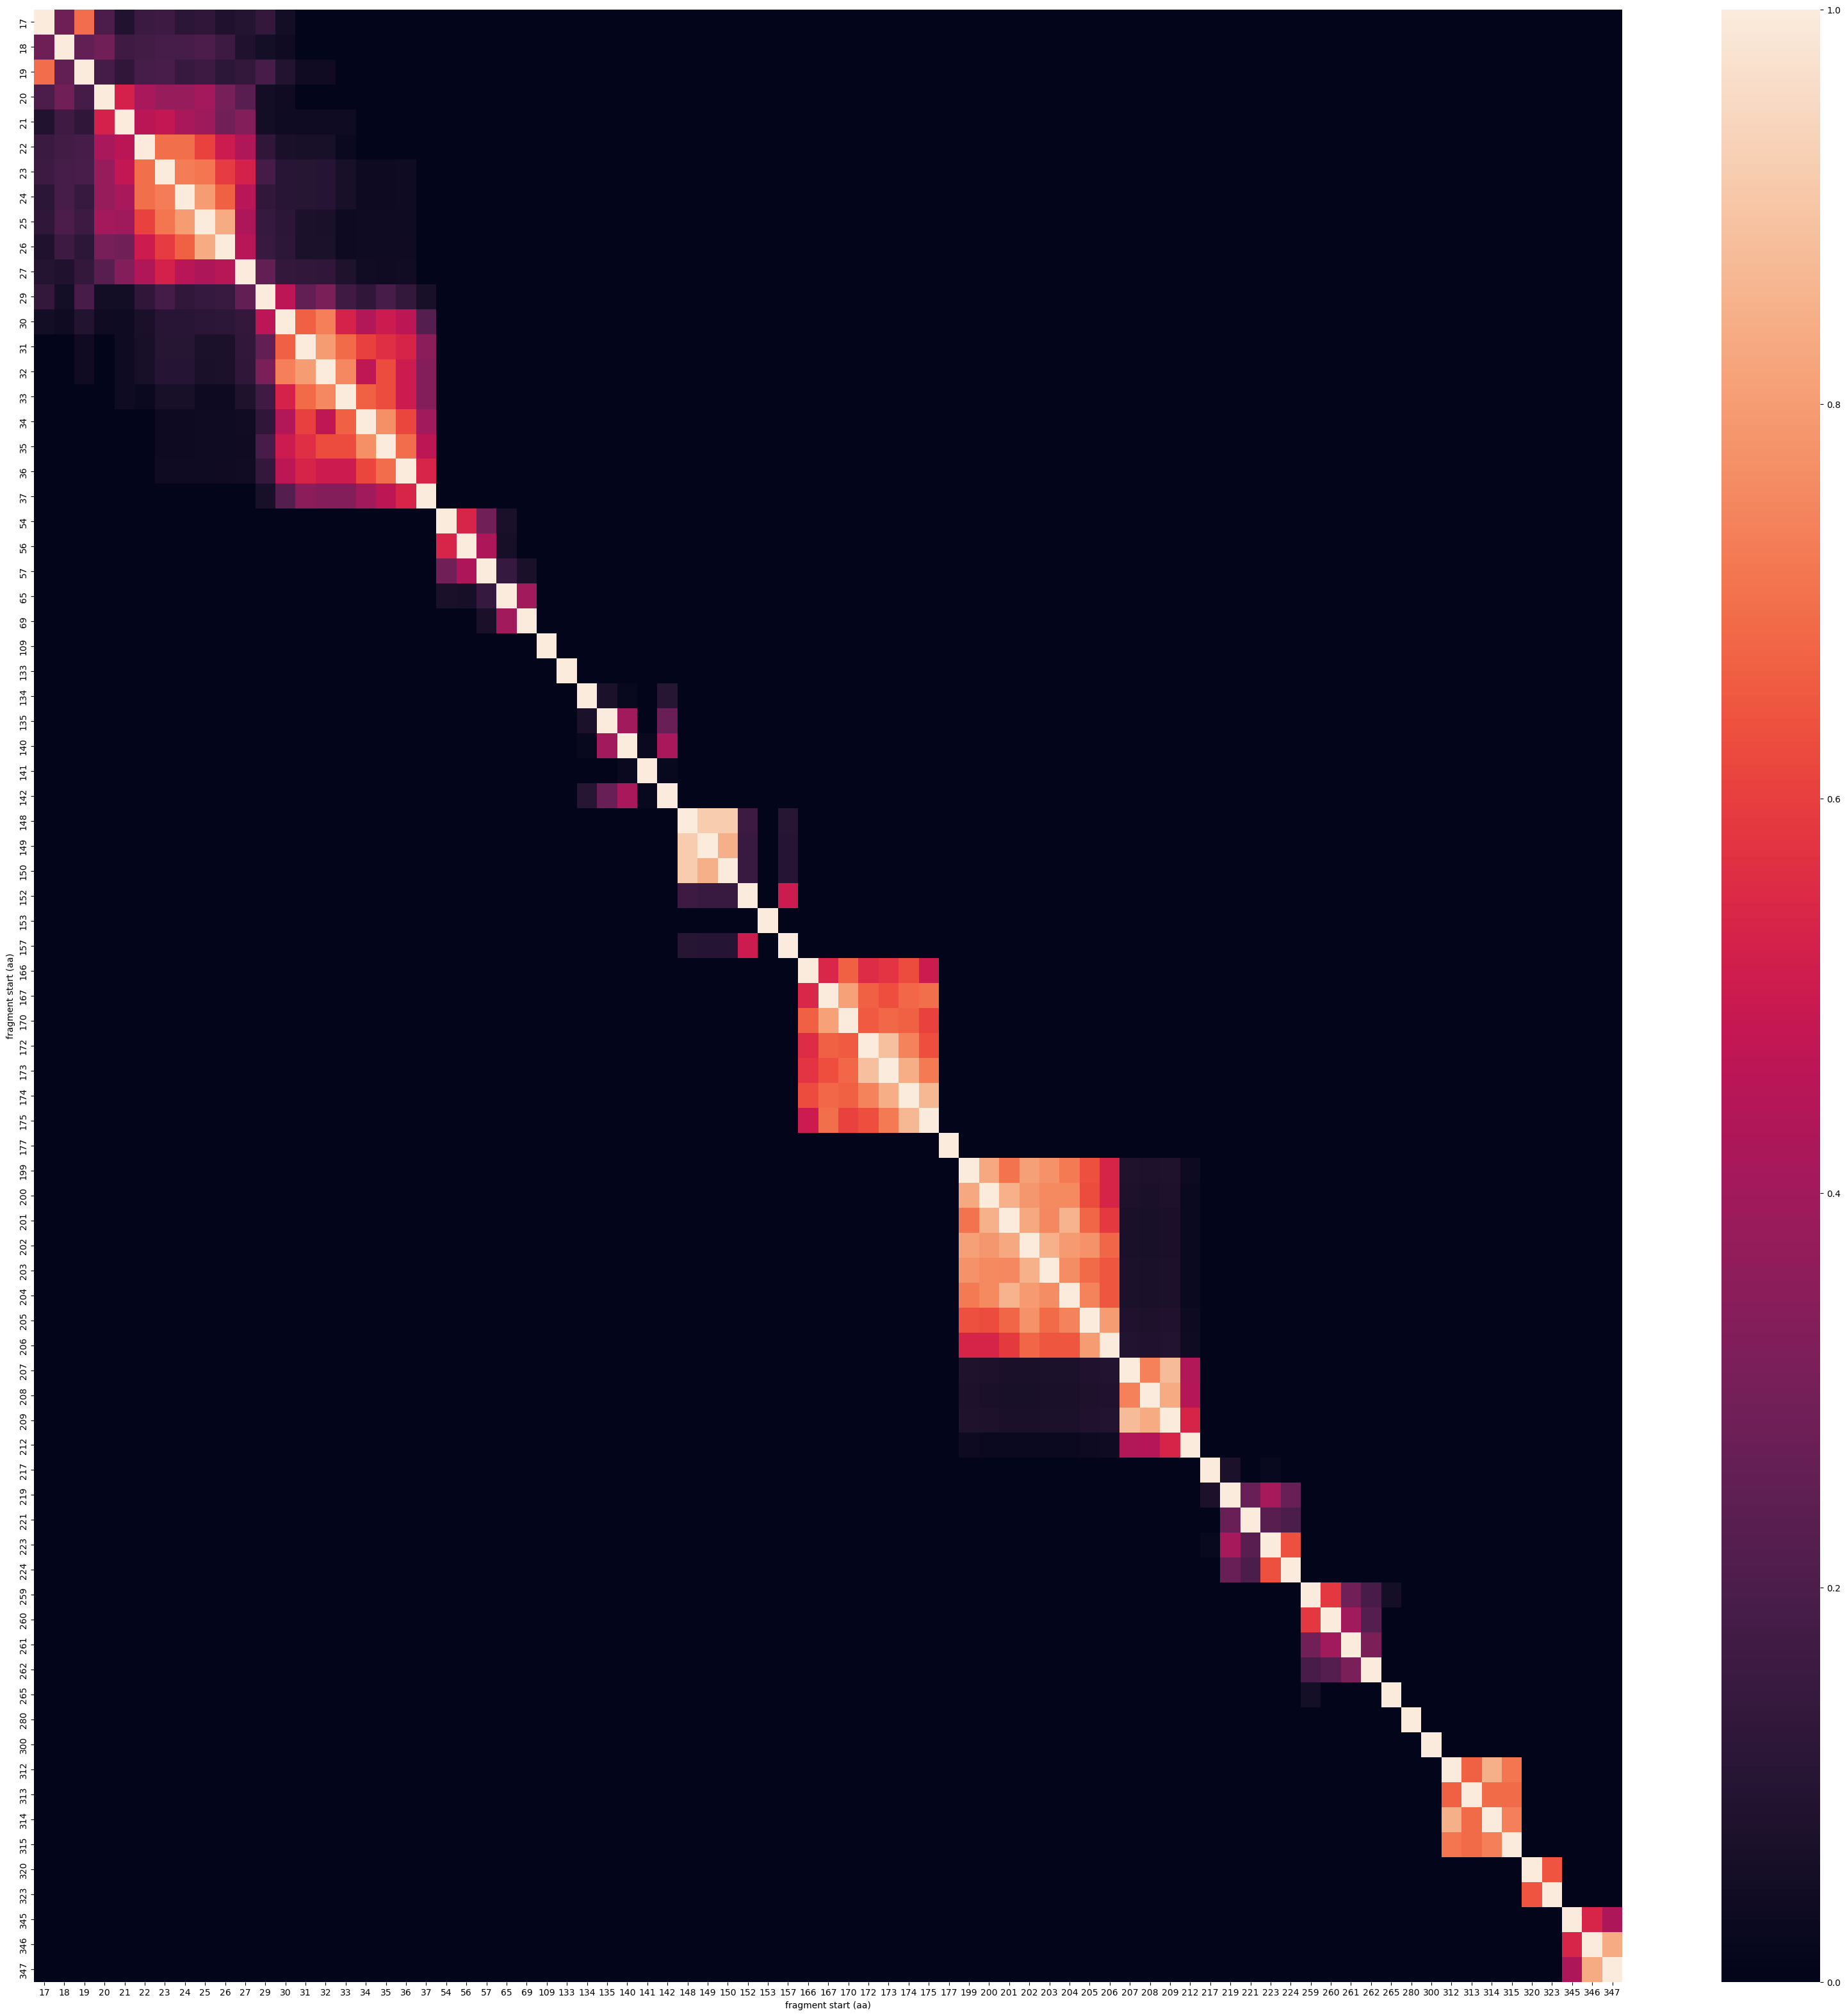

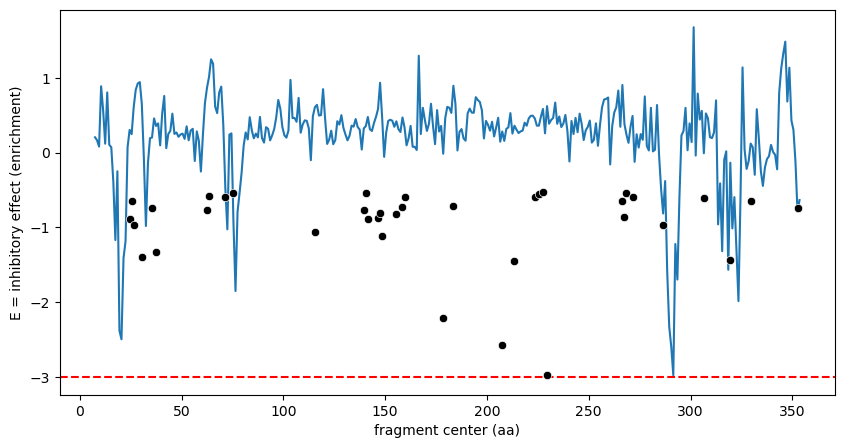

clustering 9 predictions from lptG-coding-EcoliBL21DE3_30aa_monomer_lptG ...
9 fragments in 7 clusters
[4 3 2 2 1 1 5 6 7]


<Figure size 640x480 with 0 Axes>

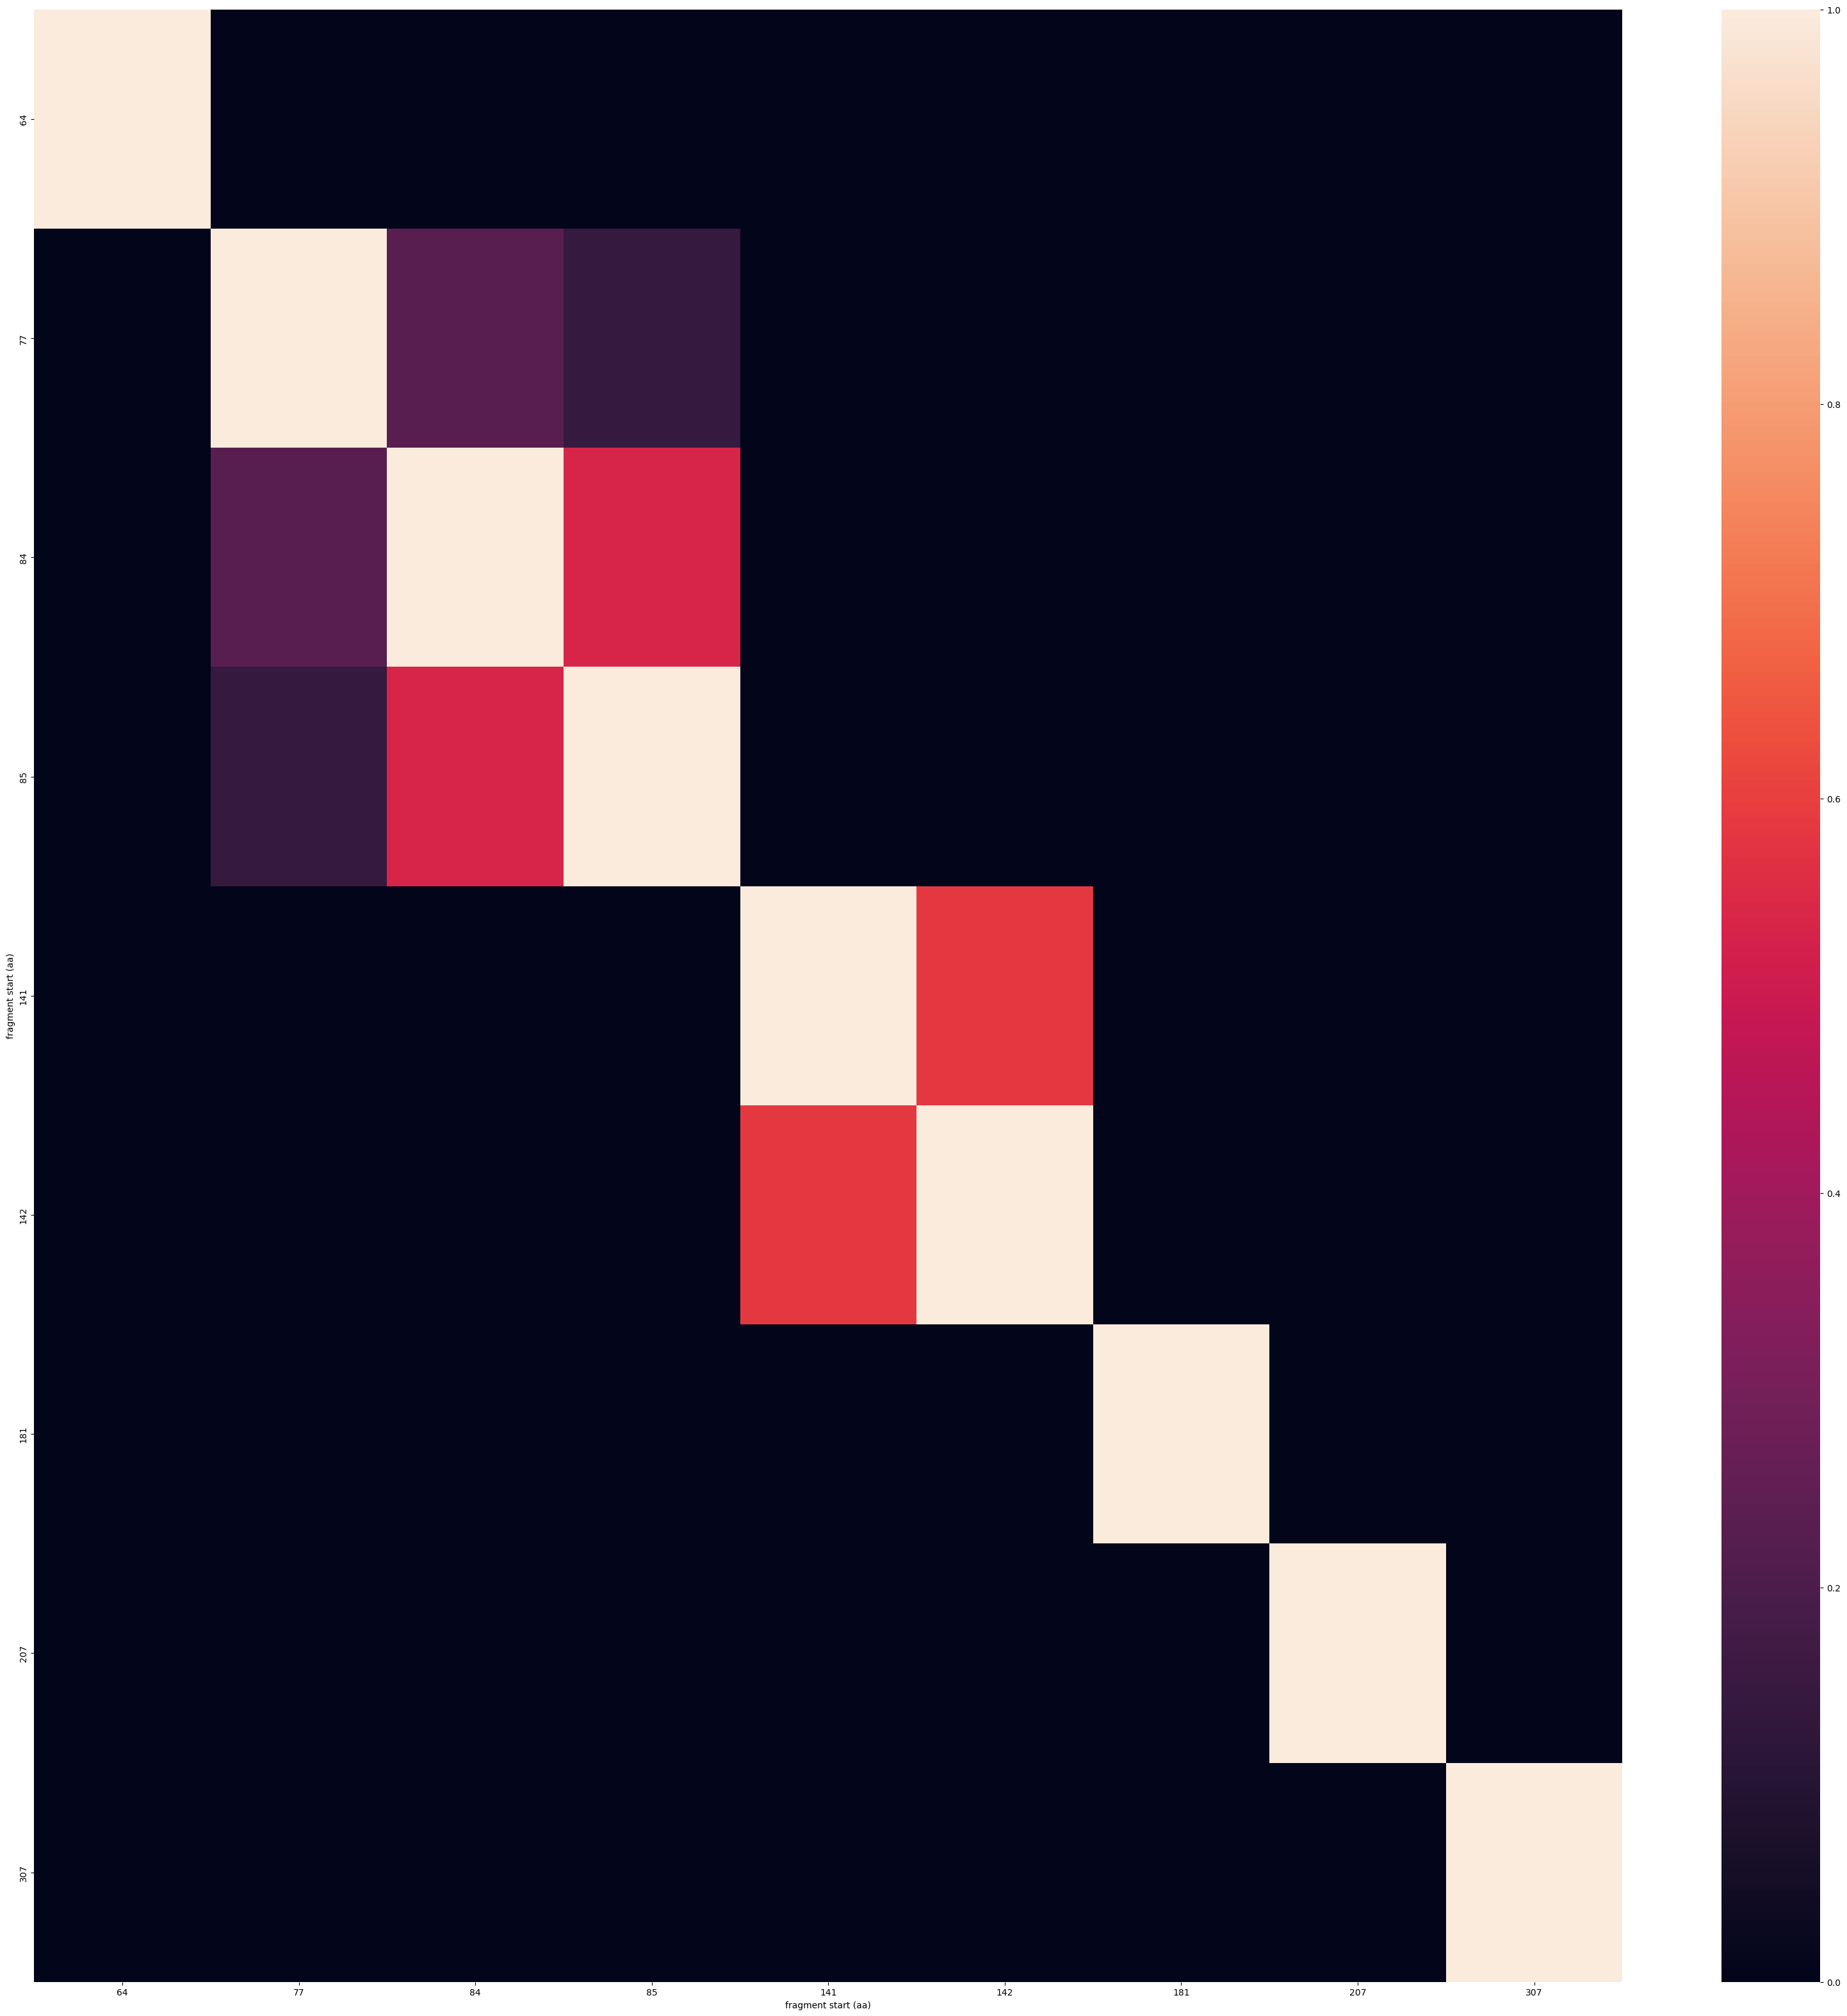

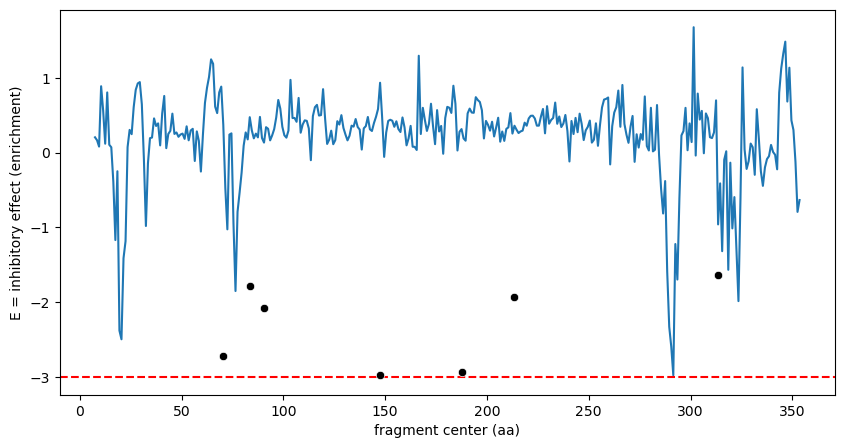

clustering 6 predictions from rpIL-coding-EcoliBL21DE3_30aa_monomer_rplL ...
6 fragments in 2 clusters
[2 1 1 1 1 1]


<Figure size 640x480 with 0 Axes>

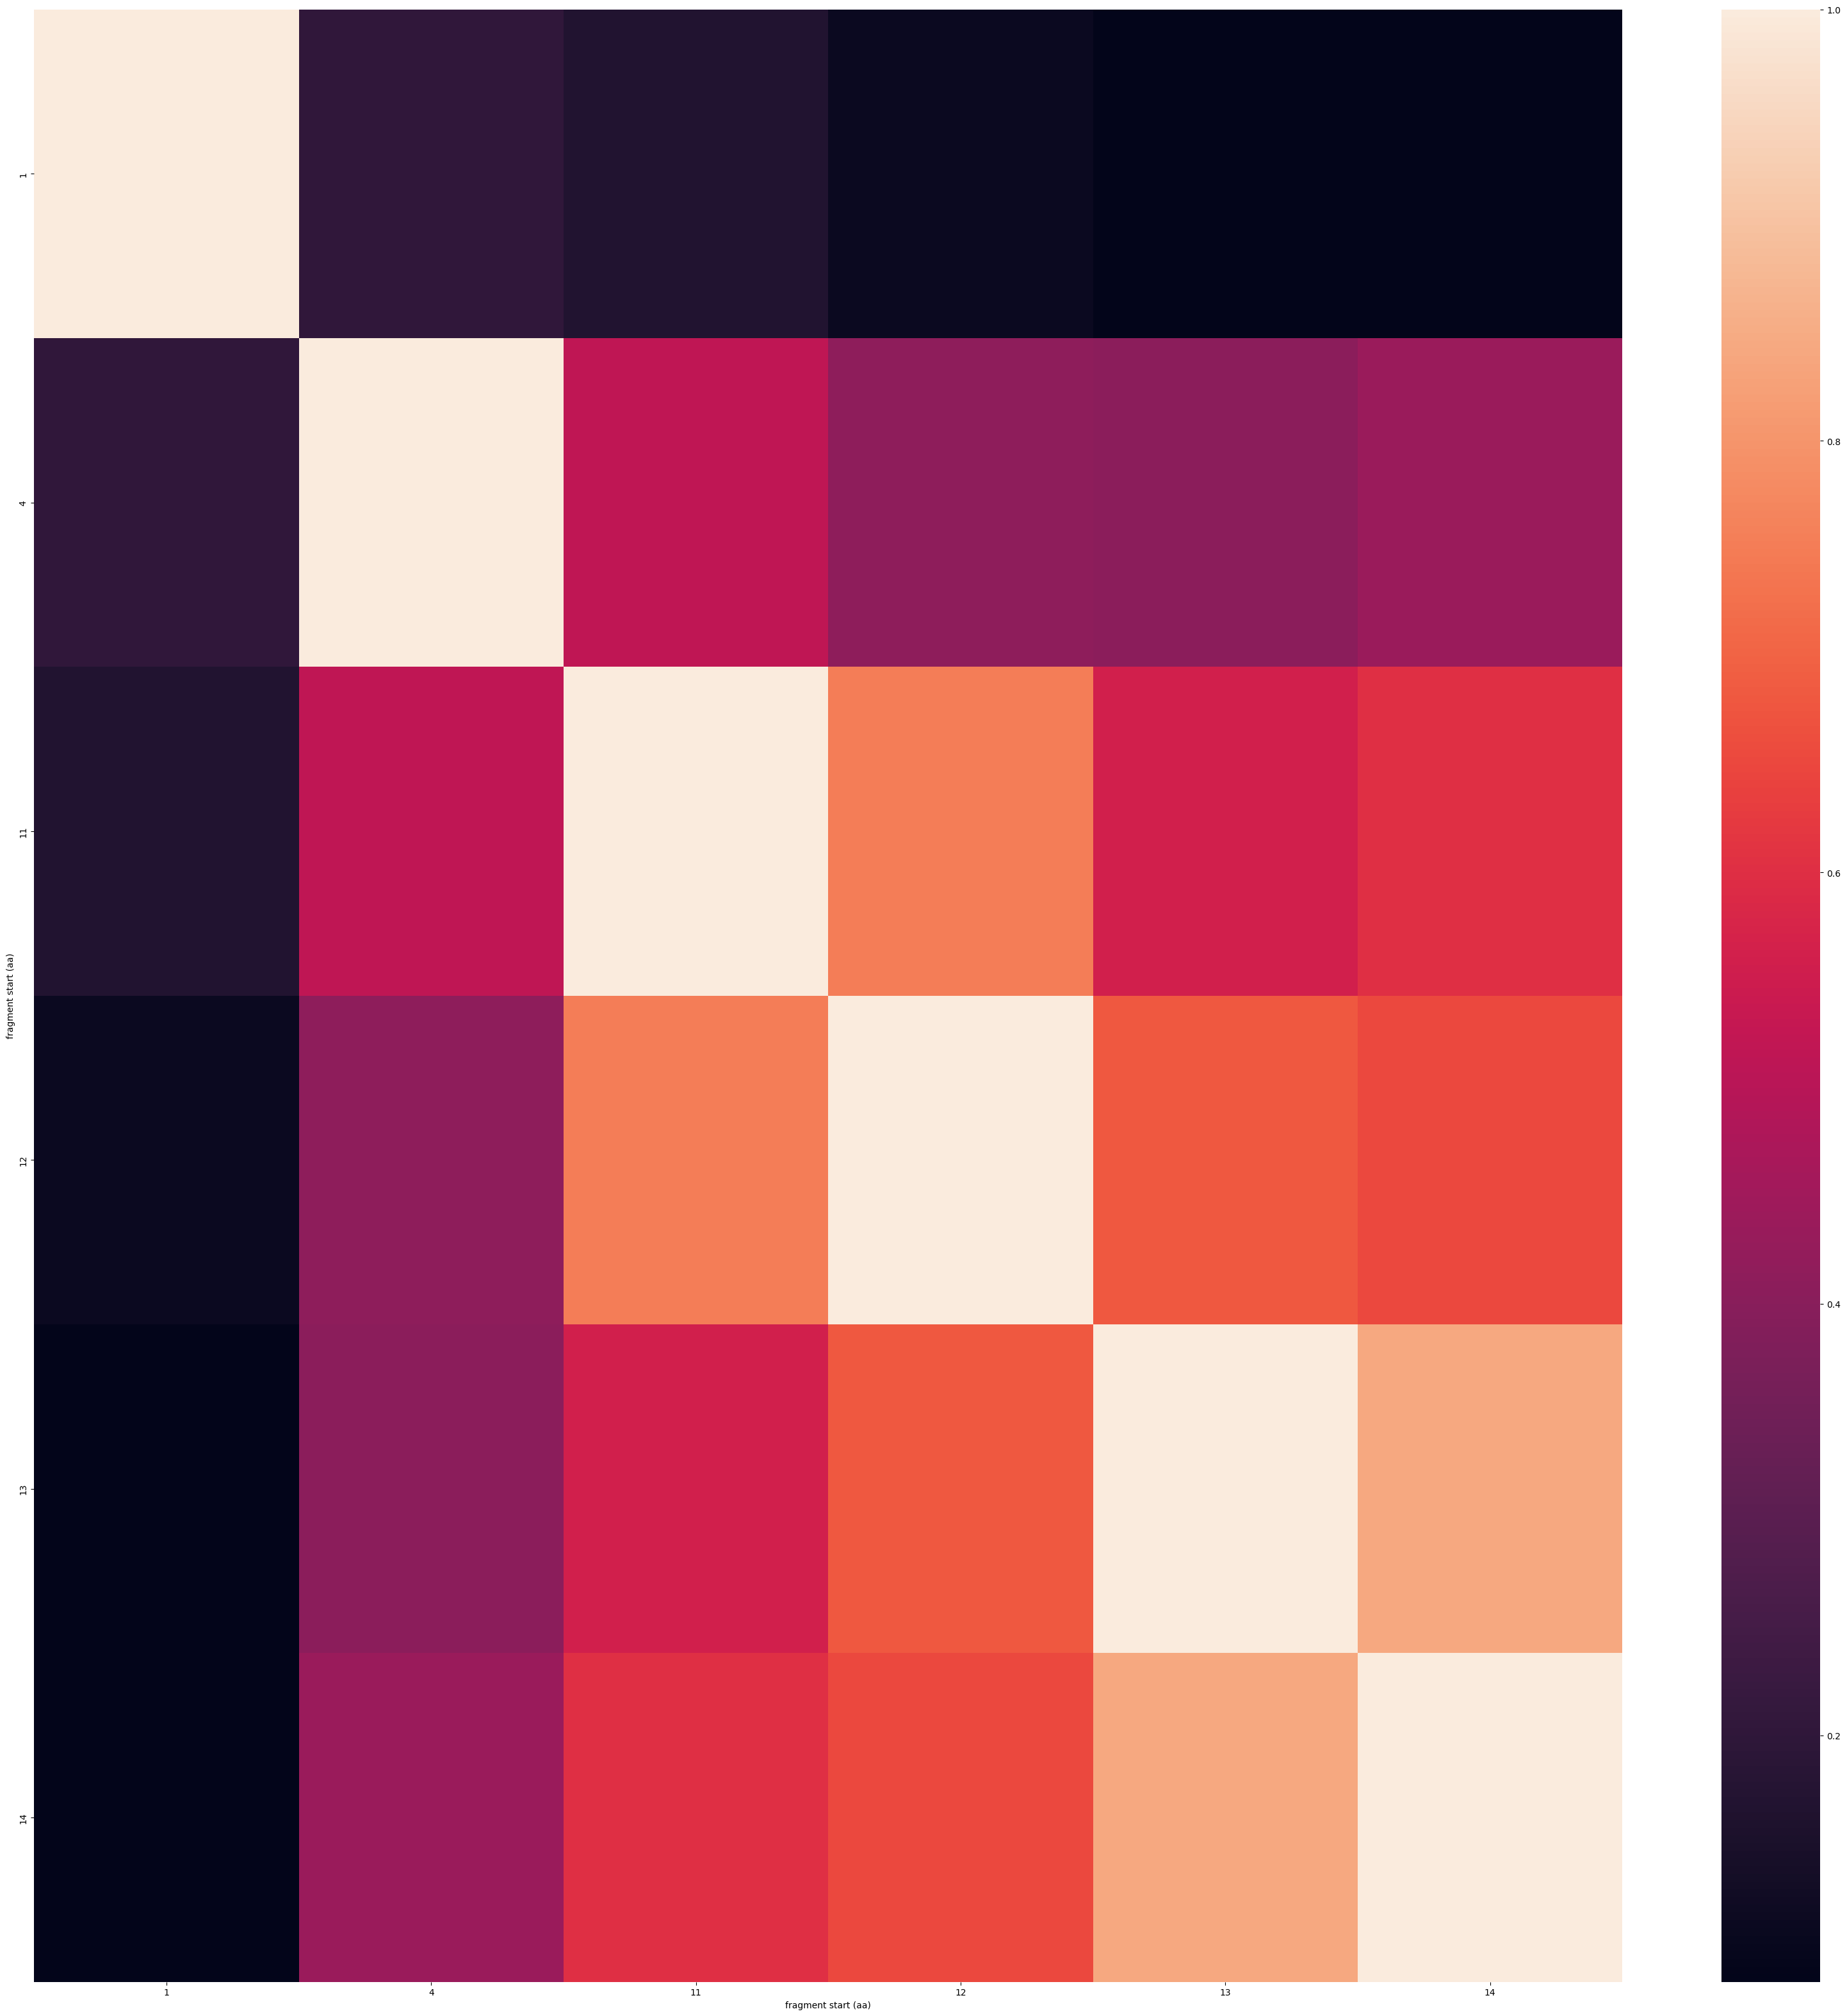

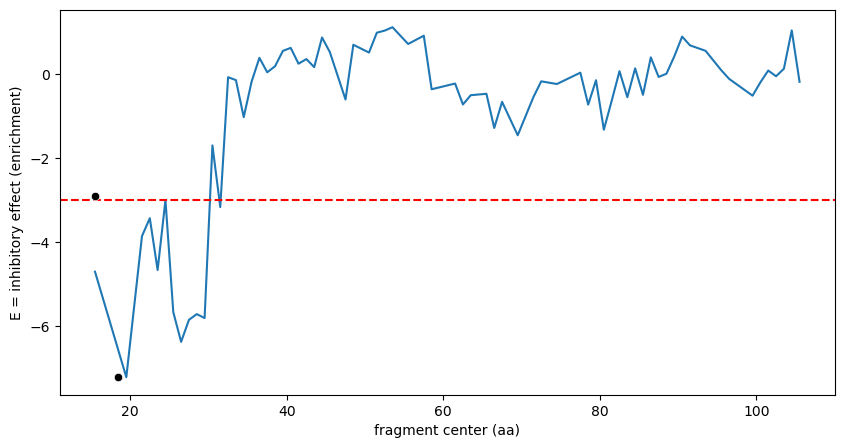

clustering 8 predictions from ssb-coding-EcoliBL21DE3_30aa_dimer_ssb ...
8 fragments in 8 clusters
[5 6 7 3 1 2 4 8]


<Figure size 640x480 with 0 Axes>

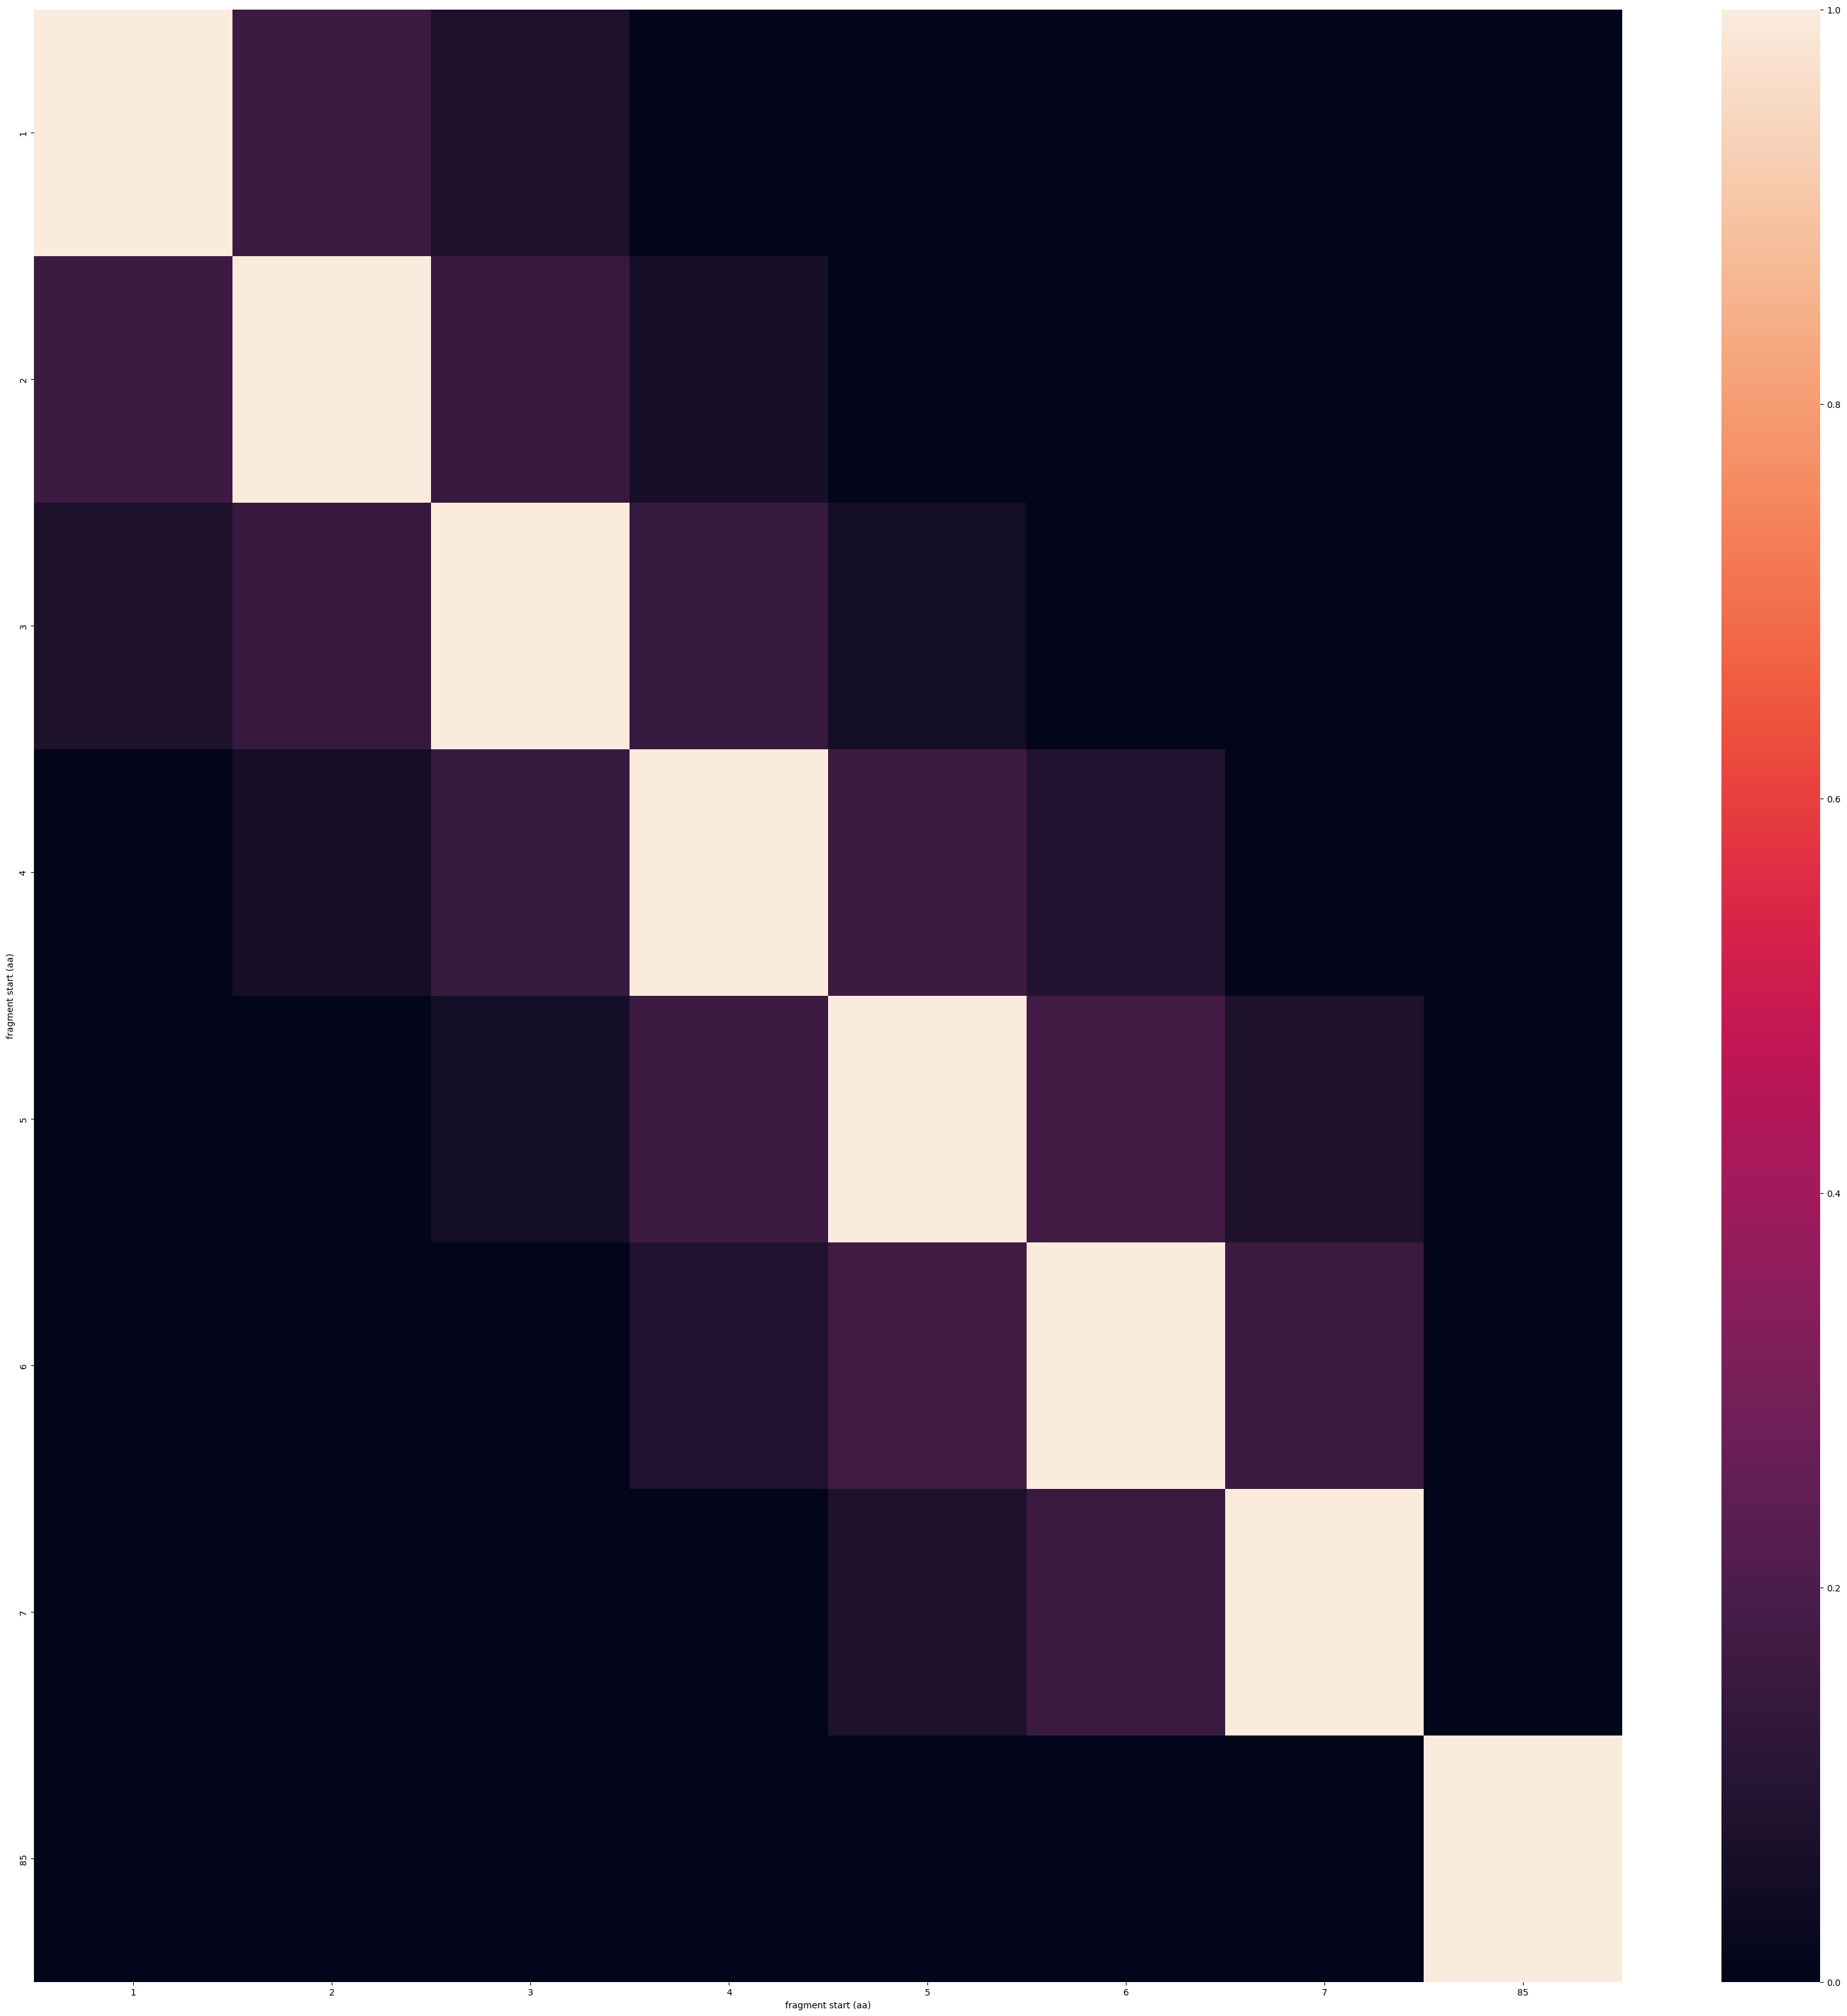

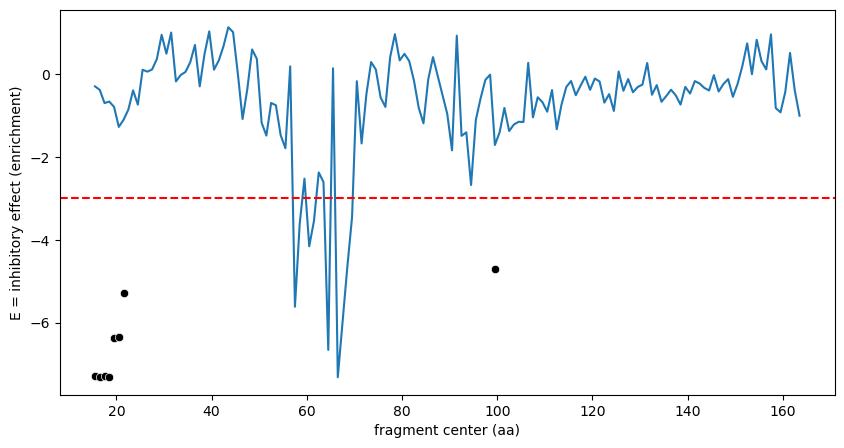

clustering 17 predictions from ssb-coding-EcoliBL21DE3_30aa_monomer_ssb ...
17 fragments in 6 clusters
[3 3 3 3 3 3 3 3 3 3 3 4 5 6 2 1 1]


<Figure size 640x480 with 0 Axes>

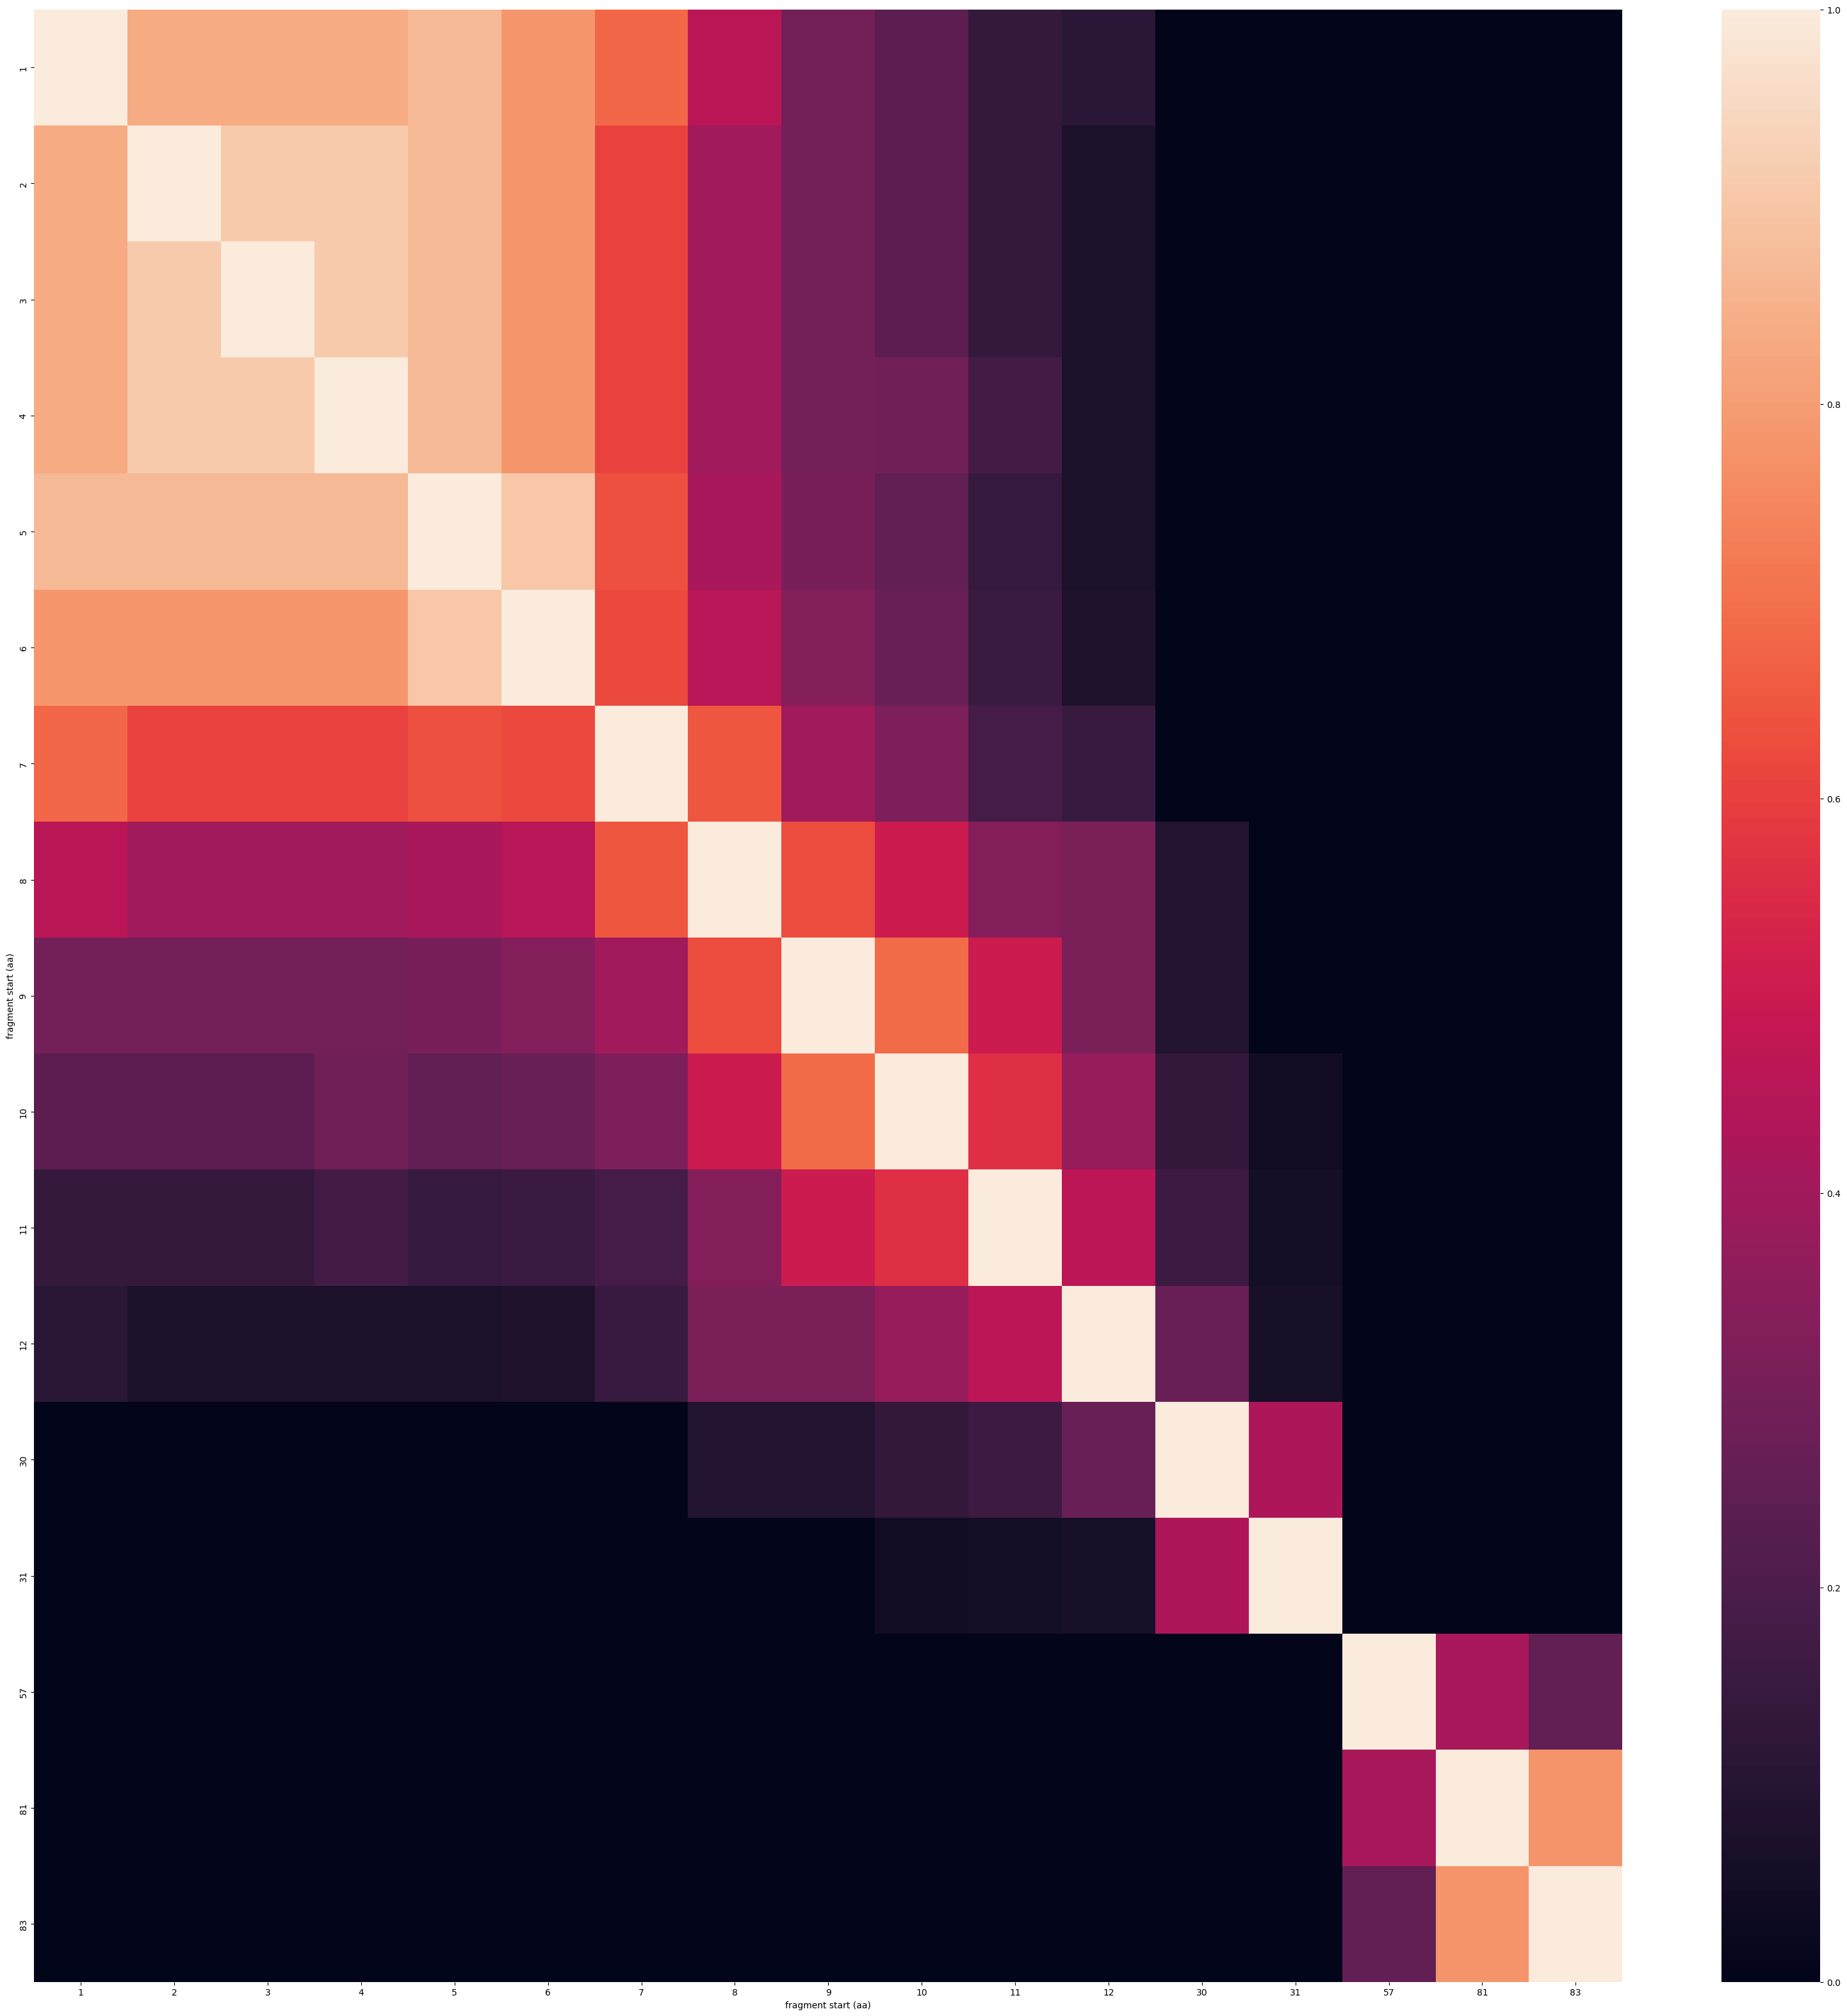

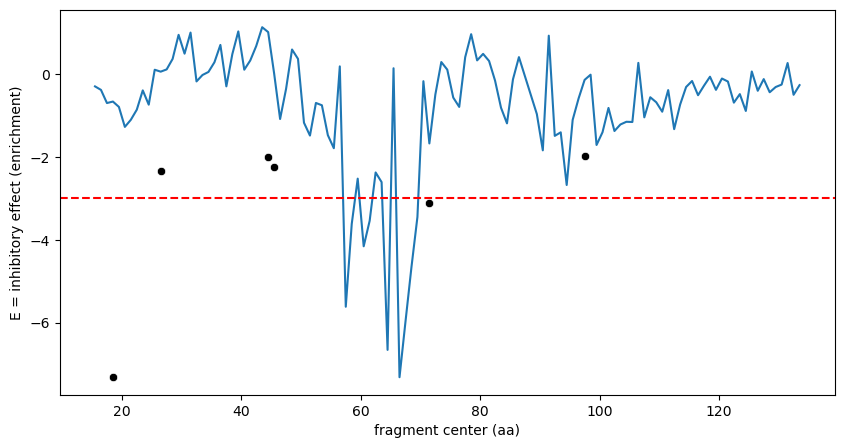

clustering 51 predictions from ssb-coding-EcoliBL21DE3_30aa_tetramer_ssb ...
51 fragments in 51 clusters
[47 20 15  9 10 11 12  7 48 29 23 40 30 49 42  1  2 34 32 46 35 45 19 21
 16 17 31 18 22 13 14  3  4 41 50  5  6 38 39 43 44 36 33 37 25 26 27 28
 51 24  8]


<Figure size 640x480 with 0 Axes>

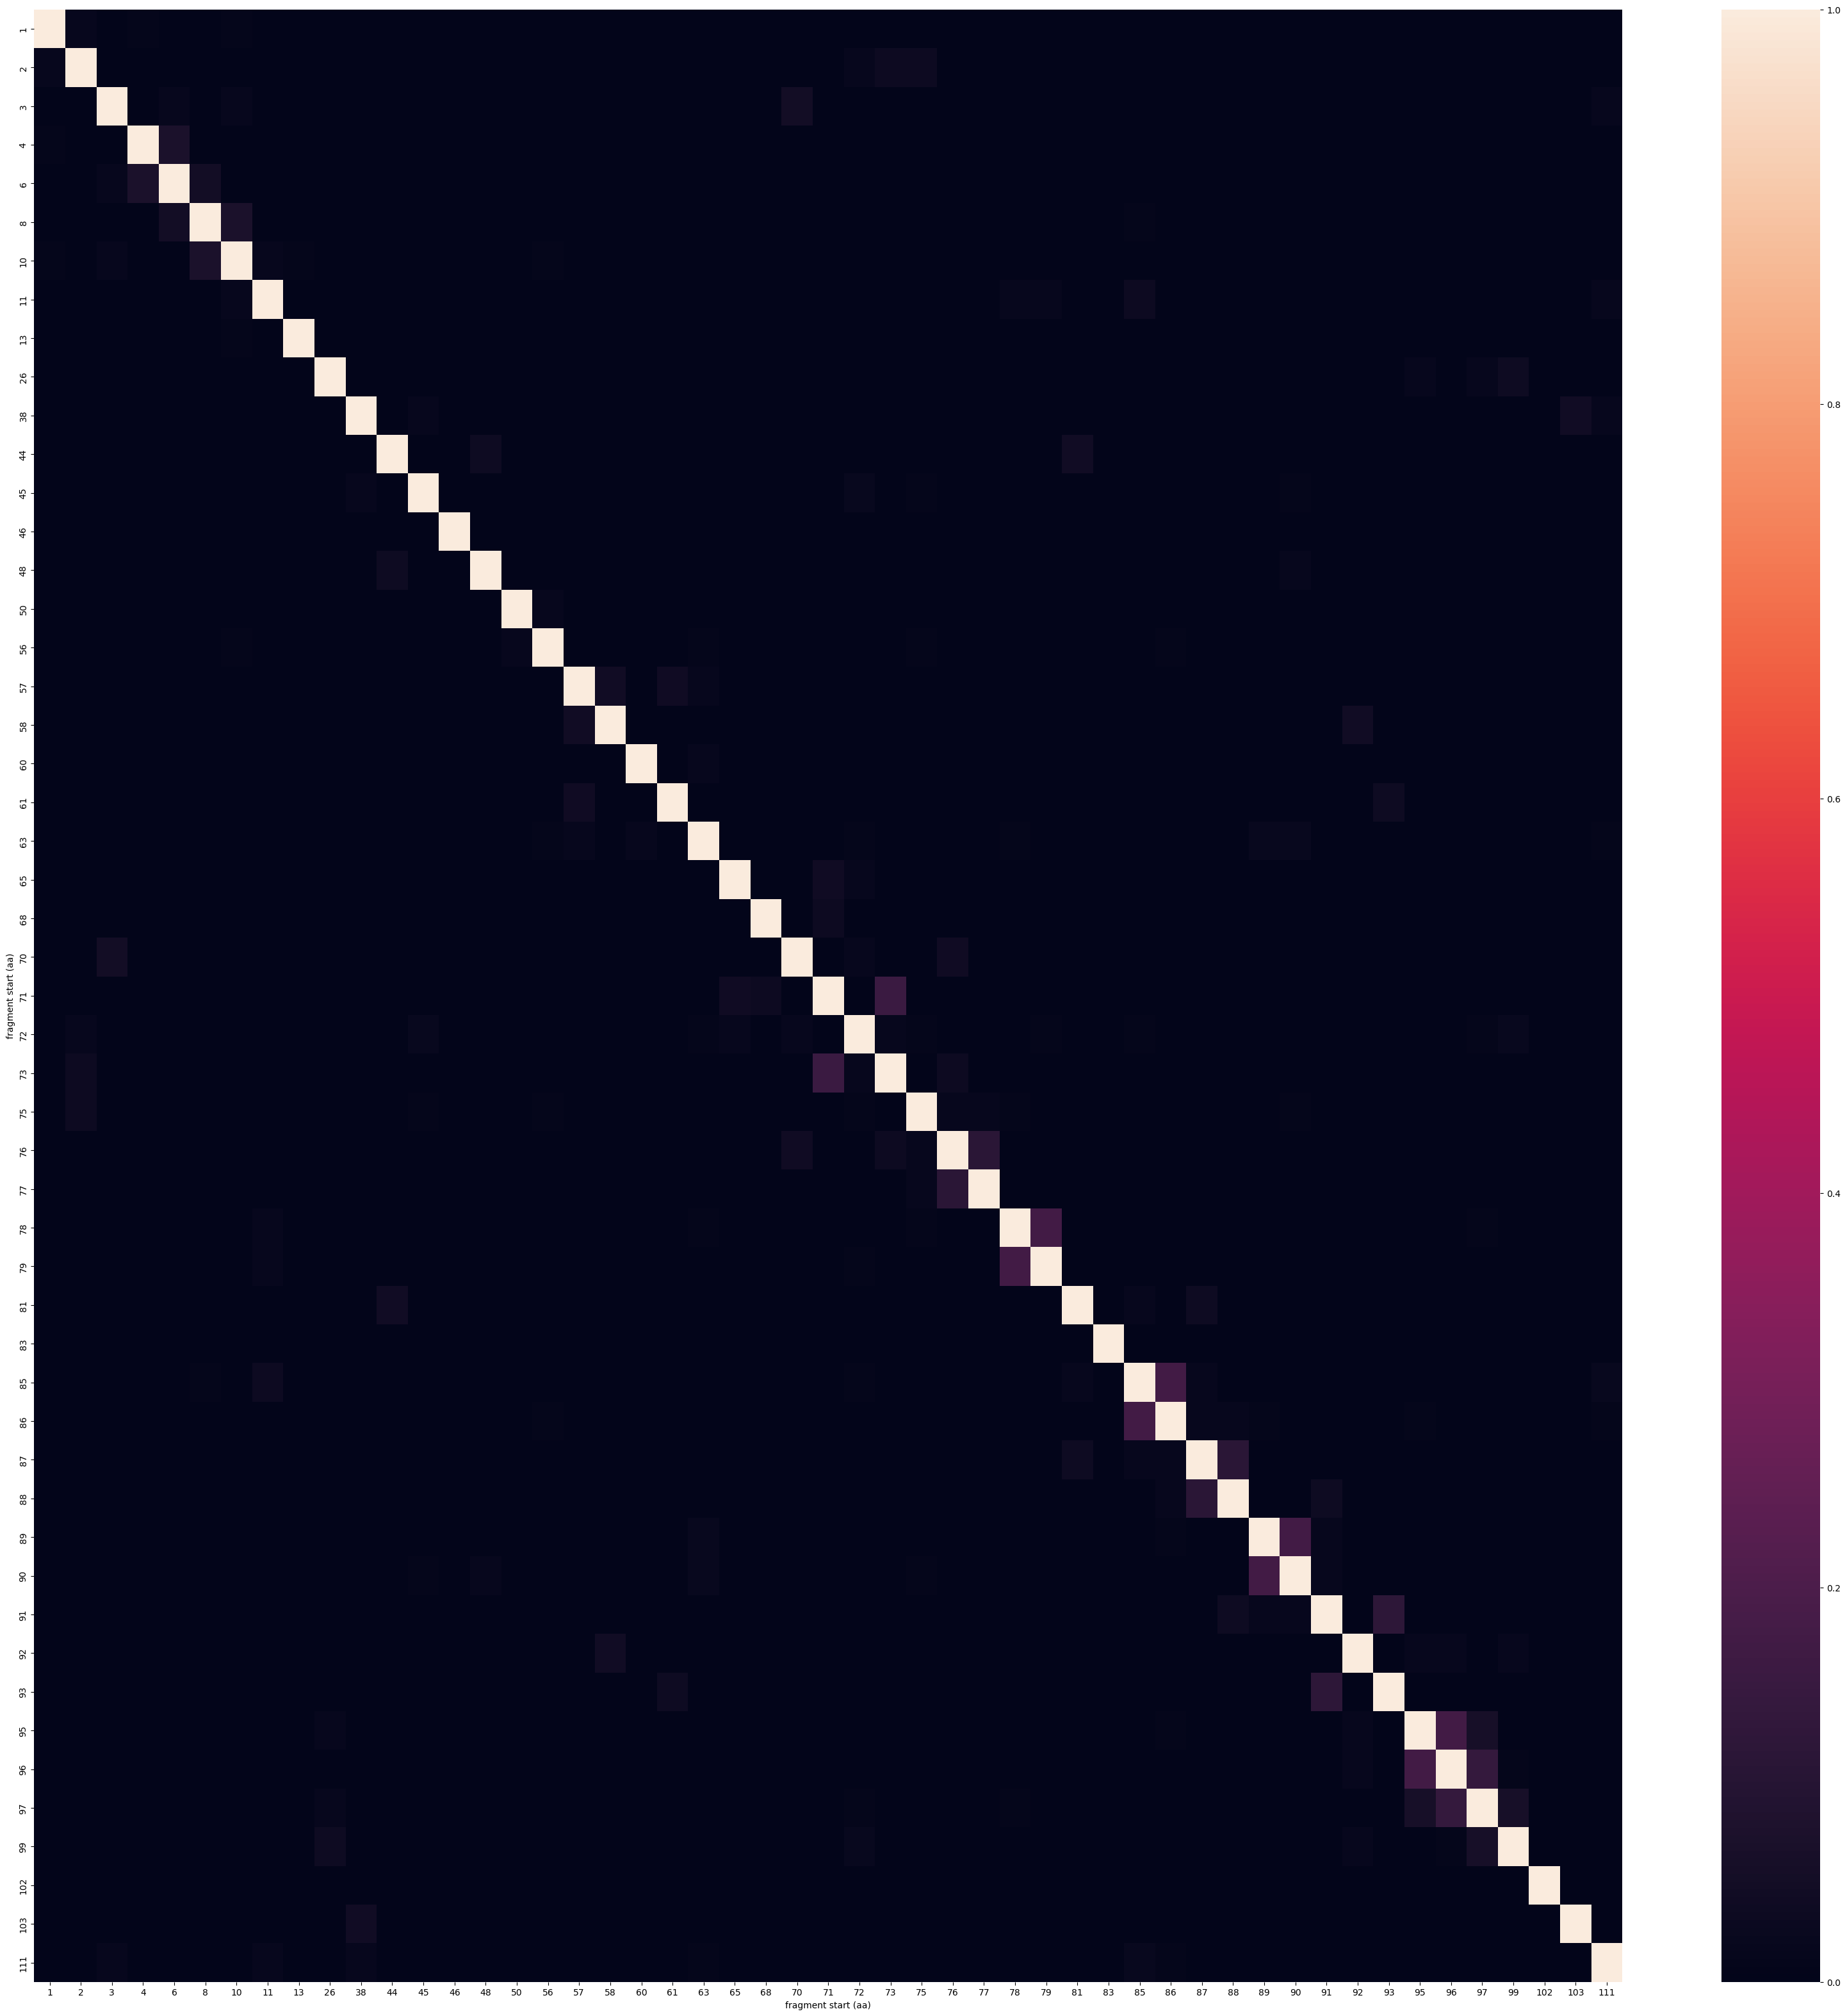

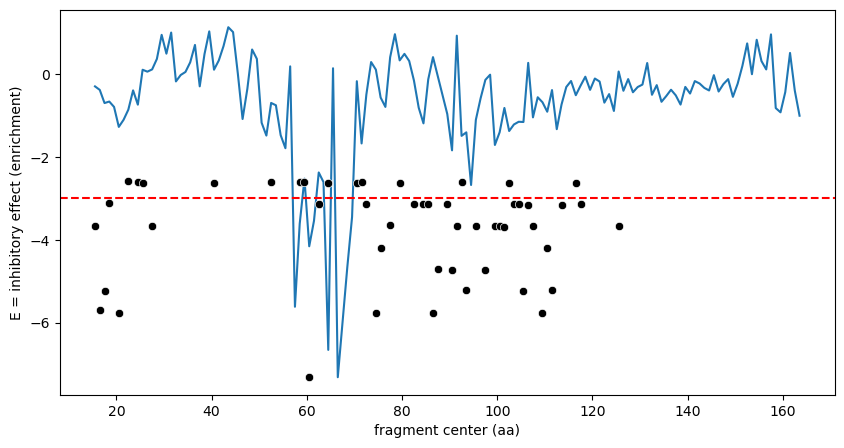

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier,contact_set,cluster,cluster_size,cluster first fragment center (aa),cluster last fragment center (aa)
28,folA_1-159_folA_35-64,35,49.5,64,0.481738,87.872333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.372169,...,NaN,NaN,NaN,NaN,NaN,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",1,1,49.5,49.5
85,folA_1-159_folA_92-121,92,106.5,121,0.487784,86.148333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.414489,...,neutral,1.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",2,1,106.5,106.5
125,FtsZ_10-316_FtsZ_2-31,2,16.5,31,0.539908,82.679000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.239451,...,negative,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",7,1,16.5,16.5
166,FtsZ_10-316_FtsZ_43-72,43,57.5,72,0.700501,88.043333,10,/data1/groups/keatinglab/swans/savinovCollabor...,both,7.005011,...,positive,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",6,16,54.5,80.5
289,FtsZ_10-316_FtsZ_166-195,166,180.5,195,0.802524,88.135333,9,/data1/groups/keatinglab/swans/savinovCollabor...,both,7.222718,...,neutral,1.0,0.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",5,22,164.5,186.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,ssb4copies_1-178_ssb_97-126,97,111.5,126,0.673047,33.358667,10,/data1/groups/keatinglab/swans/savinovCollabor...,both,6.730472,...,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",27,1,111.5,111.5
4570,ssb4copies_1-178_ssb_99-128,99,113.5,128,0.678803,45.093000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.072820,...,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",28,1,113.5,113.5
4573,ssb4copies_1-178_ssb_102-131,102,116.5,131,0.675716,46.287000,5,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.378579,...,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",51,1,116.5,116.5
4574,ssb4copies_1-178_ssb_103-132,103,117.5,132,0.674046,42.618000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.044278,...,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",24,1,117.5,117.5


<Figure size 640x480 with 0 Axes>

In [23]:
# pred_df = generatePredictionsFromAlphaFold(merge_df[merge_df['gene']!='lptG-coding-EcoliBL21DE3'],'weighted_contacts',3,0.5,False)
pred_df = generatePredictionsFromAlphaFold(merge_df,'weighted_contacts',3,0.5,False)
pred_df.to_csv("230223_alphafoldfragment_predictions.csv")
pred_df

In [24]:
pred_df.head()

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier,contact_set,cluster,cluster_size,cluster first fragment center (aa),cluster last fragment center (aa)
28,folA_1-159_folA_35-64,35,49.5,64,0.481738,87.872333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.372169,...,NaN,NaN,NaN,NaN,NaN,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",1,1,49.5,49.5
85,folA_1-159_folA_92-121,92,106.5,121,0.487784,86.148333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.414489,...,neutral,1.0,1.0,0.0,C-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",2,1,106.5,106.5
125,FtsZ_10-316_FtsZ_2-31,2,16.5,31,0.539908,82.679000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.239451,...,negative,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",7,1,16.5,16.5
166,FtsZ_10-316_FtsZ_43-72,43,57.5,72,0.700501,88.043333,10,/data1/groups/keatinglab/swans/savinovCollabor...,both,7.005011,...,positive,1.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",6,16,54.5,80.5
289,FtsZ_10-316_FtsZ_166-195,166,180.5,195,0.802524,88.135333,9,/data1/groups/keatinglab/swans/savinovCollabor...,both,7.222718,...,neutral,1.0,0.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",5,22,164.5,186.5


In [25]:
pred_df[pred_df['gene']=='ftsZ-coding-EcoliBL21DE3'][['fragment_name','E = inhibitory effect (enrichment)']]

,fragment_name,E = inhibitory effect (enrichment)
125,FtsZ_10-316_FtsZ_2-31,-0.422974
166,FtsZ_10-316_FtsZ_43-72,-0.270632
289,FtsZ_10-316_FtsZ_166-195,-9.183628
310,FtsZ_10-316_FtsZ_187-216,-3.151912
389,FtsZ_10-316_FtsZ_266-295,-1.006891
395,FtsZ_10-316_FtsZ_272-301,-0.708833
406,FtsZ_10-316_FtsZ_283-312,-0.329077
475,FtsZ_10-316_FtsZ_352-381,-3.281891


In [26]:
pred_df.gene.unique()

array(['folA-coding-EcoliBL21DE3', 'ftsZ-coding-EcoliBL21DE3',
       'groL-coding-EcoliBL21DE3', 'gyrA-coding-EcoliBL21DE3',
       'lptG-coding-EcoliBL21DE3', 'rpIL-coding-EcoliBL21DE3',
       'ssb-coding-EcoliBL21DE3'], dtype=object)

In [27]:
pred_df.columns

Index(['fragment_name', 'fragment start (aa)', 'fragment center (aa)',
       'fragment end (aa)', 'iptm', 'plddt', 'n_contacts', 'path', '_merge',
       'weighted_contacts', 'gene', 'condition', 'fragment ID',
       'fragment length (aa)', 'E = inhibitory effect (enrichment)', 'sem(E)',
       'hydrophobicity_KyteDoolittle_classifier',
       'instabIndex_Guruprasad_classifier', 'charge_Lehninger_classifier',
       'frag_contains_alphaHelix', 'frag_contains_betaStrand',
       'frag_contains_Turn', 'frag_centroid_fractional_position_classifier',
       'contact_set', 'cluster', 'cluster_size',
       'cluster first fragment center (aa)',
       'cluster last fragment center (aa)'],
      dtype='object')

In [10]:
pred_df['gene'].unique()

array(['folA-coding-EcoliBL21DE3', 'ftsZ-coding-EcoliBL21DE3',
       'groL-coding-EcoliBL21DE3', 'gyrA-coding-EcoliBL21DE3',
       'rpIL-coding-EcoliBL21DE3', 'ssb-coding-EcoliBL21DE3'],
      dtype=object)

In [11]:
pred_df[pred_df['gene']=='ssb-coding-EcoliBL21DE3']

,fragment_name,fragment start (aa),fragment center (aa),fragment end (aa),iptm,plddt,n_contacts,path,_merge,weighted_contacts,...,sem(E),hydrophobicity_KyteDoolittle_classifier,instabIndex_Guruprasad_classifier,charge_Lehninger_classifier,frag_contains_alphaHelix,frag_contains_betaStrand,frag_contains_Turn,frag_centroid_fractional_position_classifier,contact_set,cluster
4323,ssb2copies_1-178_ssb_1-30,1,15.5,30,0.671475,83.588333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.700324,...,0.204520,hydrophilic,unstable,neutral,0.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",5
4324,ssb2copies_1-178_ssb_2-31,2,16.5,31,0.673690,86.064667,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.715827,...,0.132272,hydrophilic,unstable,neutral,0.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",6
4325,ssb2copies_1-178_ssb_3-32,3,17.5,32,0.671106,87.072333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.697739,...,0.198457,hydrophilic,unstable,neutral,0.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",7
4326,ssb2copies_1-178_ssb_4-33,4,18.5,33,0.672963,87.984333,7,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.710740,...,0.395842,hydrophilic,unstable,neutral,0.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom O>), (...",3
4327,ssb2copies_1-178_ssb_5-34,5,19.5,34,0.683224,90.366333,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.099346,...,0.500904,hydrophobic,unstable,neutral,0.0,1.0,0.0,N-terminal,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4568,ssb4copies_1-178_ssb_97-126,97,111.5,126,0.673047,33.358667,10,/data1/groups/keatinglab/swans/savinovCollabor...,both,6.730472,...,0.173559,hydrophilic,stable,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",27
4570,ssb4copies_1-178_ssb_99-128,99,113.5,128,0.678803,45.093000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.072820,...,0.076902,hydrophobic,unstable,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",28
4573,ssb4copies_1-178_ssb_102-131,102,116.5,131,0.675716,46.287000,5,/data1/groups/keatinglab/swans/savinovCollabor...,both,3.378579,...,0.064853,hydrophobic,unstable,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",51
4574,ssb4copies_1-178_ssb_103-132,103,117.5,132,0.674046,42.618000,6,/data1/groups/keatinglab/swans/savinovCollabor...,both,4.044278,...,0.169561,hydrophilic,unstable,neutral,0.0,1.0,0.0,central,"[((<Atom N>, <Atom CA>, <Atom C>, <Atom CB>, <...",24
